# Theoretical Foundations of Buffer Stock Saving
<p style="text-align: center;"><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></p>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/REMARK/master?filepath=REMARKs%2FBufferStockTheory%2FBufferStockTheory.ipynb)

[This notebook](https://github.com/econ-ark/REMARK/blob/master/REMARKs/BufferStockTheory/BufferStockTheory.ipynb) uses the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit to describe the main results and reproduce the figures in the paper [Theoretical Foundations of Buffer Stock Saving](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory): <cite data-cite="6202365/8AH9AXN2"></cite>


If you are not familiar with the HARK toolkit, you may wish to browse the ["Gentle Introduction to HARK"](https://mybinder.org/v2/gh/econ-ark/DemARK/master?filepath=Gentle-Intro-To-HARK.ipynb) before continuing (since you are viewing this document, you presumably know a bit about [Jupyter Notebooks](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/)).

For instructions on how to install the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit on your computer, please refer to the [QUICK START GUIDE](https://github.com/econ-ark/HARK/blob/master/README.md). 

The main HARK tool used here is $\texttt{ConsIndShockModel.py}$, in which agents have CRRA utility and face idiosyncratic shocks to permanent and transitory income.  For an introduction to this module, see the [ConsIndShockModel.ipynb](https://econ-ark.org/notebooks) notebook at the [Econ-ARK](https://econ-ark.org) website.



In [1]:
# This cell does some setup and imports generic tools used to produce the figures

Generator=False # Is this notebook the master or is it generated?
# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

from IPython import get_ipython # In case it was run from python instead of ipython
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')
    print('You appear to be running from a terminal')
    print('By default, figures will appear one by one')
    print('Close the visible figure in order to see the next one')

# Import the plot-figure library matplotlib

import matplotlib.pyplot as plt

# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.
from matplotlib import rc
plt.rc('font', family='serif')

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it 
from distutils.spawn import find_executable
iflatexExists=False
if find_executable('latex'):
    iflatexExists=True
    
params = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

plt.rc('font', family='serif')
plt.rc('text', usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

# The tools for navigating the filesystem
import sys
import os

sys.path.insert(0, os.path.abspath('../../lib')) # REMARKs directory is two down from root 

from HARK.utilities import plotFuncsDer, plotFuncs
from copy import copy, deepcopy

# Define (and create, if necessary) the figures directory "Figures"
if Generator:
    my_file_path = os.path.dirname(os.path.abspath("BufferStockTheory.ipynb")) # Find pathname to this file:
    Figures_HARK_dir = os.path.join(my_file_path,"Figures/") # LaTeX document assumes figures will be here
    Figures_HARK_dir = os.path.join(my_file_path,"/tmp/Figures/") # Uncomment to make figures outside of git path
    if not os.path.exists(Figures_HARK_dir):
        os.makedirs(Figures_HARK_dir)

## [The Problem](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) 

The paper defines and calibrates a small set of parameters:

| Parameter | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\PermGroFac}{\Gamma}\PermGroFac$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\newcommand{\Rfree}{\mathrm{\mathsf{R}}}\Rfree$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\newcommand{\DiscFac}{\beta}\DiscFac$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\newcommand{\CRRA}{\rho}\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\newcommand{\UnempPrb}{\wp}\UnempPrb$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
| $\newcommand{\IncUnemp}{\mu}\IncUnemp$ | Income when Unemployed | $\texttt{IncUnemp}$ | 0. |
| $\newcommand{\PermShkStd}{\sigma_\psi}\PermShkStd$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\newcommand{\TranShkStd}{\sigma_\theta}\TranShkStd$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

For a microeconomic consumer with 'Market Resources' (net worth plus current income) $M_{t}$, end-of-period assets $A_{t}$ will be the amount remaining after consumption of $C_{t}$.  <!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $A_{t}$ augmented by return factor $R$:-->
\begin{eqnarray}
A_{t}   &=&M_{t}-C_{t}  \label{eq:DBCparts} \\
%B_{t+1}   & = & A_{t} R \notag \\
\end{eqnarray}

The consumer's permanent noncapital income $P$ grows by a predictable factor $\PermGroFac$ and is subject to an unpredictable lognormally distributed multiplicative shock $\mathbb{E}_{t}[\psi_{t+1}]=1$, 
\begin{eqnarray}
P_{t+1} & = & P_{t} \PermGroFac \psi_{t+1}
\end{eqnarray}

and actual income is permanent income multiplied by a logormal multiplicative transitory shock, $\mathbb{E}_{t}[\theta_{t+1}]=1$, so that next period's market resources are
\begin{eqnarray}
%M_{t+1} &=& B_{t+1} +P_{t+1}\theta_{t+1},  \notag
M_{t+1} &=& A_{t}R +P_{t+1}\theta_{t+1}.  \notag
\end{eqnarray}

When the consumer has a CRRA utility function $u(c)=\frac{c^{1-\rho}}{1-\rho}$, the paper shows that the problem can be written in terms of ratios of money variables to permanent income, e.g. $m_{t} \equiv M_{t}/P_{t}$, and the Bellman form of [the problem reduces to](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Related-Problem):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& R/(\Gamma \psi_{t+1}) a_t + \theta_{t+1} \\
\end{eqnarray*}


In [2]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
PermGroFac = 1.03
Rfree      = 1.04
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.005
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
base_params = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
base_params['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
base_params['Rfree']      = Rfree          # Interest factor on assets
base_params['DiscFac']    = DiscFac        # Time Preference Factor
base_params['CRRA']       = CRRA           # Coefficient of relative risk aversion
base_params['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
base_params['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
base_params['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
base_params['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params['CubicBool']    = True    # Use cubic spline interpolation
base_params['T_cycle']      = 1       # No 'seasonal' cycles
base_params['BoroCnstArt']  = None    # No artificial borrowing constraint

In [4]:
# from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
# The code below is what you get if you exeute the command on the prior line
# from a location where HARK is accessible.  It is included here because the
# latest pip-installable version of HARK does not include the impatience conditions
# (though the online one does)

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from builtins import str
from builtins import range
from builtins import object
from copy import copy, deepcopy
import numpy as np
from scipy.optimize import newton
from HARK import AgentType, Solution, NullFunc, HARKobject
from HARK.utilities import warnings  # Because of "patch" to warnings modules
from HARK.interpolation import CubicInterp, LowerEnvelope, LinearInterp
from HARK.simulation import drawDiscrete, drawBernoulli, drawLognormal, drawUniform
from HARK.utilities import approxMeanOneLognormal, addDiscreteOutcomeConstantMean,\
                           combineIndepDstns, makeGridExpMult, CRRAutility, CRRAutilityP, \
                           CRRAutilityPP, CRRAutilityP_inv, CRRAutility_invP, CRRAutility_inv, \
                           CRRAutilityP_invP

utility       = CRRAutility
utilityP      = CRRAutilityP
utilityPP     = CRRAutilityPP
utilityP_inv  = CRRAutilityP_inv
utility_invP  = CRRAutility_invP
utility_inv   = CRRAutility_inv
utilityP_invP = CRRAutilityP_invP

# =====================================================================
# === Classes that help solve consumption-saving models ===
# =====================================================================

class ConsumerSolution(Solution):
    '''
    A class representing the solution of a single period of a consumption-saving
    problem.  The solution must include a consumption function and marginal
    value function.

    Here and elsewhere in the code, Nrm indicates that variables are normalized
    by permanent income.
    '''
    distance_criteria = ['vPfunc']

    def __init__(self, cFunc=None, vFunc=None,
                       vPfunc=None, vPPfunc=None,
                       mNrmMin=None, hNrm=None, MPCmin=None, MPCmax=None):
        '''
        The constructor for a new ConsumerSolution object.

        Parameters
        ----------
        cFunc : function
            The consumption function for this period, defined over market
            resources: c = cFunc(m).
        vFunc : function
            The beginning-of-period value function for this period, defined over
            market resources: v = vFunc(m).
        vPfunc : function
            The beginning-of-period marginal value function for this period,
            defined over market resources: vP = vPfunc(m).
        vPPfunc : function
            The beginning-of-period marginal marginal value function for this
            period, defined over market resources: vPP = vPPfunc(m).
        mNrmMin : float
            The minimum allowable market resources for this period; the consump-
            tion function (etc) are undefined for m < mNrmMin.
        hNrm : float
            Human wealth after receiving income this period: PDV of all future
            income, ignoring mortality.
        MPCmin : float
            Infimum of the marginal propensity to consume this period.
            MPC --> MPCmin as m --> infinity.
        MPCmax : float
            Supremum of the marginal propensity to consume this period.
            MPC --> MPCmax as m --> mNrmMin.

        Returns
        -------
        None
        '''
        # Change any missing function inputs to NullFunc
        if cFunc is None:
            cFunc = NullFunc()
        if vFunc is None:
            vFunc = NullFunc()
        if vPfunc is None:
            vPfunc = NullFunc()
        if vPPfunc is None:
            vPPfunc = NullFunc()
        self.cFunc        = cFunc
        self.vFunc        = vFunc
        self.vPfunc       = vPfunc
        self.vPPfunc      = vPPfunc
        self.mNrmMin      = mNrmMin
        self.hNrm         = hNrm
        self.MPCmin       = MPCmin
        self.MPCmax       = MPCmax

    def appendSolution(self,new_solution):
        '''
        Appends one solution to another to create a ConsumerSolution whose
        attributes are lists.  Used in ConsMarkovModel, where we append solutions
        *conditional* on a particular value of a Markov state to each other in
        order to get the entire solution.

        Parameters
        ----------
        new_solution : ConsumerSolution
            The solution to a consumption-saving problem; each attribute is a
            list representing state-conditional values or functions.

        Returns
        -------
        None
        '''
        if type(self.cFunc)!=list:
            # Then we assume that self is an empty initialized solution instance.
            # Begin by checking this is so.
            assert NullFunc().distance(self.cFunc) == 0, 'appendSolution called incorrectly!'

            # We will need the attributes of the solution instance to be lists.  Do that here.
            self.cFunc       = [new_solution.cFunc]
            self.vFunc       = [new_solution.vFunc]
            self.vPfunc      = [new_solution.vPfunc]
            self.vPPfunc     = [new_solution.vPPfunc]
            self.mNrmMin     = [new_solution.mNrmMin]
        else:
            self.cFunc.append(new_solution.cFunc)
            self.vFunc.append(new_solution.vFunc)
            self.vPfunc.append(new_solution.vPfunc)
            self.vPPfunc.append(new_solution.vPPfunc)
            self.mNrmMin.append(new_solution.mNrmMin)


class ValueFunc(HARKobject):
    '''
    A class for representing a value function.  The underlying interpolation is
    in the space of (m,u_inv(v)); this class "re-curves" to the value function.
    '''
    distance_criteria = ['func','CRRA']

    def __init__(self,vFuncNvrs,CRRA):
        '''
        Constructor for a new value function object.

        Parameters
        ----------
        vFuncNvrs : function
            A real function representing the value function composed with the
            inverse utility function, defined on market resources: u_inv(vFunc(m))
        CRRA : float
            Coefficient of relative risk aversion.

        Returns
        -------
        None
        '''
        self.func = deepcopy(vFuncNvrs)
        self.CRRA = CRRA

    def __call__(self,m):
        '''
        Evaluate the value function at given levels of market resources m.

        Parameters
        ----------
        m : float or np.array
            Market resources (normalized by permanent income) whose value is to
            be found.

        Returns
        -------
        v : float or np.array
            Lifetime value of beginning this period with market resources m; has
            same size as input m.
        '''
        return utility(self.func(m),gam=self.CRRA)


class MargValueFunc(HARKobject):
    '''
    A class for representing a marginal value function in models where the
    standard envelope condition of v'(m) = u'(c(m)) holds (with CRRA utility).
    '''
    distance_criteria = ['cFunc','CRRA']

    def __init__(self,cFunc,CRRA):
        '''
        Constructor for a new marginal value function object.

        Parameters
        ----------
        cFunc : function
            A real function representing the marginal value function composed
            with the inverse marginal utility function, defined on market
            resources: uP_inv(vPfunc(m)).  Called cFunc because when standard
            envelope condition applies, uP_inv(vPfunc(m)) = cFunc(m).
        CRRA : float
            Coefficient of relative risk aversion.

        Returns
        -------
        None
        '''
        self.cFunc = deepcopy(cFunc)
        self.CRRA = CRRA

    def __call__(self,m):
        '''
        Evaluate the marginal value function at given levels of market resources m.

        Parameters
        ----------
        m : float or np.array
            Market resources (normalized by permanent income) whose marginal
            value is to be found.

        Returns
        -------
        vP : float or np.array
            Marginal lifetime value of beginning this period with market
            resources m; has same size as input m.
        '''
        return utilityP(self.cFunc(m),gam=self.CRRA)

    def derivative(self,m):
        '''
        Evaluate the derivative of the marginal value function at given levels
        of market resources m; this is the marginal marginal value function.

        Parameters
        ----------
        m : float or np.array
            Market resources (normalized by permanent income) whose marginal
            marginal value is to be found.

        Returns
        -------
        vPP : float or np.array
            Marginal marginal lifetime value of beginning this period with market
            resources m; has same size as input m.
        '''
        c, MPC = self.cFunc.eval_with_derivative(m)
        return MPC*utilityPP(c,gam=self.CRRA)


class MargMargValueFunc(HARKobject):
    '''
    A class for representing a marginal marginal value function in models where
    the standard envelope condition of v'(m) = u'(c(m)) holds (with CRRA utility).
    '''
    distance_criteria = ['cFunc','CRRA']

    def __init__(self,cFunc,CRRA):
        '''
        Constructor for a new marginal marginal value function object.

        Parameters
        ----------
        cFunc : function
            A real function representing the marginal value function composed
            with the inverse marginal utility function, defined on market
            resources: uP_inv(vPfunc(m)).  Called cFunc because when standard
            envelope condition applies, uP_inv(vPfunc(m)) = cFunc(m).
        CRRA : float
            Coefficient of relative risk aversion.

        Returns
        -------
        None
        '''
        self.cFunc = deepcopy(cFunc)
        self.CRRA = CRRA

    def __call__(self,m):
        '''
        Evaluate the marginal marginal value function at given levels of market
        resources m.

        Parameters
        ----------
        m : float or np.array
            Market resources (normalized by permanent income) whose marginal
            marginal value is to be found.

        Returns
        -------
        vPP : float or np.array
            Marginal marginal lifetime value of beginning this period with market
            resources m; has same size as input m.
        '''
        c, MPC = self.cFunc.eval_with_derivative(m)
        return MPC*utilityPP(c,gam=self.CRRA)




# =====================================================================
# === Classes and functions that solve consumption-saving models ===
# =====================================================================

class ConsPerfForesightSolver(object):
    '''
    A class for solving a one period perfect foresight consumption-saving problem.
    An instance of this class is created by the function solvePerfForesight in each period.
    '''
    def __init__(self,solution_next,DiscFac,LivPrb,CRRA,Rfree,PermGroFac):
        '''
        Constructor for a new ConsPerfForesightSolver.

        Parameters
        ----------
        solution_next : ConsumerSolution
            The solution to next period's one-period problem.
        DiscFac : float
            Intertemporal discount factor for future utility.
        LivPrb : float
            Survival probability; likelihood of being alive at the beginning of
            the next period.
        CRRA : float
            Coefficient of relative risk aversion.
        Rfree : float
            Risk free interest factor on end-of-period assets.
        PermGroFac : float
            Expected permanent income growth factor at the end of this period.

        Returns:
        ----------
        None
        '''
        # We ask that HARK users define single-letter variables they use in a dictionary
        # attribute called notation.
        # Do that first.
        self.notation = {'a': 'assets after all actions',
                         'm': 'market resources at decision time',
                         'c': 'consumption'}
        self.assignParameters(solution_next,DiscFac,LivPrb,CRRA,Rfree,PermGroFac)

    def assignParameters(self,solution_next,DiscFac,LivPrb,CRRA,Rfree,PermGroFac):
        '''
        Saves necessary parameters as attributes of self for use by other methods.

        Parameters
        ----------
        solution_next : ConsumerSolution
            The solution to next period's one period problem.
        DiscFac : float
            Intertemporal discount factor for future utility.
        LivPrb : float
            Survival probability; likelihood of being alive at the beginning of
            the succeeding period.
        CRRA : float
            Coefficient of relative risk aversion.
        Rfree : float
            Risk free interest factor on end-of-period assets.
        PermGroFac : float
            Expected permanent income growth factor at the end of this period.

        Returns
        -------
        none
        '''
        self.solution_next  = solution_next
        self.DiscFac        = DiscFac
        self.LivPrb         = LivPrb
        self.CRRA           = CRRA
        self.Rfree          = Rfree
        self.PermGroFac     = PermGroFac

    def defUtilityFuncs(self):
        '''
        Defines CRRA utility function for this period (and its derivatives),
        saving them as attributes of self for other methods to use.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        self.u   = lambda c : utility(c,gam=self.CRRA)  # utility function
        self.uP  = lambda c : utilityP(c,gam=self.CRRA) # marginal utility function
        self.uPP = lambda c : utilityPP(c,gam=self.CRRA)# marginal marginal utility function

    def defValueFuncs(self):
        '''
        Defines the value and marginal value function for this period.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        MPCnvrs      = self.MPC**(-self.CRRA/(1.0-self.CRRA))
        vFuncNvrs    = LinearInterp(np.array([self.mNrmMin, self.mNrmMin+1.0]),np.array([0.0, MPCnvrs]))
        self.vFunc   = ValueFunc(vFuncNvrs,self.CRRA)
        self.vPfunc  = MargValueFunc(self.cFunc,self.CRRA)

    def makePFcFunc(self):
        '''
        Makes the (linear) consumption function for this period.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        # Calculate human wealth this period (and lower bound of m)
        self.hNrmNow = (self.PermGroFac/self.Rfree)*(self.solution_next.hNrm + 1.0)
        self.mNrmMin = -self.hNrmNow
        # Calculate the (constant) marginal propensity to consume
        PatFac       = ((self.Rfree*self.DiscFacEff)**(1.0/self.CRRA))/self.Rfree
        self.MPC     = 1.0/(1.0 + PatFac/self.solution_next.MPCmin)
        # Construct the consumption function
        self.cFunc   = LinearInterp([self.mNrmMin, self.mNrmMin+1.0],[0.0, self.MPC])
        # Add two attributes to enable calculation of steady state market resources
        self.ExIncNext = 1.0 # Perfect foresight income of 1
        self.mNrmMinNow = self.mNrmMin # Relabeling for compatibility with addSSmNrm

    def addSSmNrm(self,solution):
        '''
        Finds steady state (normalized) market resources and adds it to the
        solution.  This is the level of market resources such that the expectation
        of market resources in the next period is unchanged.  This value doesn't
        necessarily exist.

        Parameters
        ----------
        solution : ConsumerSolution
            Solution to this period's problem, which must have attribute cFunc.
        Returns
        -------
        solution : ConsumerSolution
            Same solution that was passed, but now with the attribute mNrmSS.
        '''
        # Make a linear function of all combinations of c and m that yield mNext = mNow
        mZeroChangeFunc = lambda m : (1.0-self.PermGroFac/self.Rfree)*m + (self.PermGroFac/self.Rfree)*self.ExIncNext

        # Find the steady state level of market resources
        searchSSfunc = lambda m : solution.cFunc(m) - mZeroChangeFunc(m) # A zero of this is SS market resources
        m_init_guess = self.mNrmMinNow + self.ExIncNext # Minimum market resources plus next income is okay starting guess
        try:
            mNrmSS = newton(searchSSfunc,m_init_guess)
        except:
            mNrmSS = None

        # Add mNrmSS to the solution and return it
        solution.mNrmSS = mNrmSS
        return solution

    def solve(self):
        '''
        Solves the one period perfect foresight consumption-saving problem.

        Parameters
        ----------
        none

        Returns
        -------
        solution : ConsumerSolution
            The solution to this period's problem.
        '''
        self.defUtilityFuncs()
        self.DiscFacEff = self.DiscFac*self.LivPrb
        self.makePFcFunc()
        self.defValueFuncs()
        solution = ConsumerSolution(cFunc=self.cFunc, vFunc=self.vFunc, vPfunc=self.vPfunc,
                                    mNrmMin=self.mNrmMin, hNrm=self.hNrmNow,
                                    MPCmin=self.MPC, MPCmax=self.MPC)
        #solution = self.addSSmNrm(solution)
        return solution


def solvePerfForesight(solution_next,DiscFac,LivPrb,CRRA,Rfree,PermGroFac):
    '''
    Solves a single period consumption-saving problem for a consumer with perfect foresight.

    Parameters
    ----------
    solution_next : ConsumerSolution
        The solution to next period's one period problem.
    DiscFac : float
        Intertemporal discount factor for future utility.
    LivPrb : float
        Survival probability; likelihood of being alive at the beginning of
        the succeeding period.
    CRRA : float
        Coefficient of relative risk aversion.
    Rfree : float
        Risk free interest factor on end-of-period assets.
    PermGroFac : float
        Expected permanent income growth factor at the end of this period.

    Returns
    -------
    solution : ConsumerSolution
            The solution to this period's problem.
    '''
    solver = ConsPerfForesightSolver(solution_next,DiscFac,LivPrb,CRRA,Rfree,PermGroFac)
    solution = solver.solve()
    return solution


###############################################################################
###############################################################################
class ConsIndShockSetup(ConsPerfForesightSolver):
    '''
    A superclass for solvers of one period consumption-saving problems with
    constant relative risk aversion utility and permanent and transitory shocks
    to income.  Has methods to set up but not solve the one period problem.
    '''
    def __init__(self,solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,Rfree,
                      PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,CubicBool):
        '''
        Constructor for a new solver-setup for problems with income subject to
        permanent and transitory shocks.

        Parameters
        ----------
        solution_next : ConsumerSolution
            The solution to next period's one period problem.
        IncomeDstn : [np.array]
            A list containing three arrays of floats, representing a discrete
            approximation to the income process between the period being solved
            and the one immediately following (in solution_next). Order: event
            probabilities, permanent shocks, transitory shocks.
        LivPrb : float
            Survival probability; likelihood of being alive at the beginning of
            the succeeding period.
        DiscFac : float
            Intertemporal discount factor for future utility.
        CRRA : float
            Coefficient of relative risk aversion.
        Rfree : float
            Risk free interest factor on end-of-period assets.
        PermGroFac : float
            Expected permanent income growth factor at the end of this period.
        BoroCnstArt: float or None
            Borrowing constraint for the minimum allowable assets to end the
            period with.  If it is less than the natural borrowing constraint,
            then it is irrelevant; BoroCnstArt=None indicates no artificial bor-
            rowing constraint.
        aXtraGrid: np.array
            Array of "extra" end-of-period asset values-- assets above the
            absolute minimum acceptable level.
        vFuncBool: boolean
            An indicator for whether the value function should be computed and
            included in the reported solution.
        CubicBool: boolean
            An indicator for whether the solver should use cubic or linear inter-
            polation.

        Returns
        -------
        None
        '''
        self.assignParameters(solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,Rfree,
                                PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,CubicBool)
        self.defUtilityFuncs()

    def assignParameters(self,solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,Rfree,
                                PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,CubicBool):
        '''
        Assigns period parameters as attributes of self for use by other methods

        Parameters
        ----------
        solution_next : ConsumerSolution
            The solution to next period's one period problem.
        IncomeDstn : [np.array]
            A list containing three arrays of floats, representing a discrete
            approximation to the income process between the period being solved
            and the one immediately following (in solution_next). Order: event
            probabilities, permanent shocks, transitory shocks.
        LivPrb : float
            Survival probability; likelihood of being alive at the beginning of
            the succeeding period.
        DiscFac : float
            Intertemporal discount factor for future utility.
        CRRA : float
            Coefficient of relative risk aversion.
        Rfree : float
            Risk free interest factor on end-of-period assets.
        PermGroFac : float
            Expected permanent income growth factor at the end of this period.
        BoroCnstArt: float or None
            Borrowing constraint for the minimum allowable assets to end the
            period with.  If it is less than the natural borrowing constraint,
            then it is irrelevant; BoroCnstArt=None indicates no artificial bor-
            rowing constraint.
        aXtraGrid: np.array
            Array of "extra" end-of-period asset values-- assets above the
            absolute minimum acceptable level.
        vFuncBool: boolean
            An indicator for whether the value function should be computed and
            included in the reported solution.
        CubicBool: boolean
            An indicator for whether the solver should use cubic or linear inter-
            polation.

        Returns
        -------
        none
        '''
        ConsPerfForesightSolver.assignParameters(self,solution_next,DiscFac,LivPrb,
                                                CRRA,Rfree,PermGroFac)
        self.BoroCnstArt    = BoroCnstArt
        self.IncomeDstn     = IncomeDstn
        self.aXtraGrid      = aXtraGrid
        self.vFuncBool      = vFuncBool
        self.CubicBool      = CubicBool


    def defUtilityFuncs(self):
        '''
        Defines CRRA utility function for this period (and its derivatives,
        and their inverses), saving them as attributes of self for other methods
        to use.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        ConsPerfForesightSolver.defUtilityFuncs(self)
        self.uPinv     = lambda u : utilityP_inv(u,gam=self.CRRA)
        self.uPinvP    = lambda u : utilityP_invP(u,gam=self.CRRA)
        self.uinvP     = lambda u : utility_invP(u,gam=self.CRRA)
        if self.vFuncBool:
            self.uinv  = lambda u : utility_inv(u,gam=self.CRRA)


    def setAndUpdateValues(self,solution_next,IncomeDstn,LivPrb,DiscFac):
        '''
        Unpacks some of the inputs (and calculates simple objects based on them),
        storing the results in self for use by other methods.  These include:
        income shocks and probabilities, next period's marginal value function
        (etc), the probability of getting the worst income shock next period,
        the patience factor, human wealth, and the bounding MPCs.

        Parameters
        ----------
        solution_next : ConsumerSolution
            The solution to next period's one period problem.
        IncomeDstn : [np.array]
            A list containing three arrays of floats, representing a discrete
            approximation to the income process between the period being solved
            and the one immediately following (in solution_next). Order: event
            probabilities, permanent shocks, transitory shocks.
        LivPrb : float
            Survival probability; likelihood of being alive at the beginning of
            the succeeding period.
        DiscFac : float
            Intertemporal discount factor for future utility.

        Returns
        -------
        None
        '''
        self.DiscFacEff       = DiscFac*LivPrb # "effective" discount factor
        self.ShkPrbsNext      = IncomeDstn[0]
        self.PermShkValsNext  = IncomeDstn[1]
        self.TranShkValsNext  = IncomeDstn[2]
        self.PermShkMinNext   = np.min(self.PermShkValsNext)
        self.TranShkMinNext   = np.min(self.TranShkValsNext)
        self.vPfuncNext       = solution_next.vPfunc
        self.WorstIncPrb      = np.sum(self.ShkPrbsNext[
                                (self.PermShkValsNext*self.TranShkValsNext)==
                                (self.PermShkMinNext*self.TranShkMinNext)])

        if self.CubicBool:
            self.vPPfuncNext  = solution_next.vPPfunc

        if self.vFuncBool:
            self.vFuncNext    = solution_next.vFunc

        # Update the bounding MPCs and PDV of human wealth:
        self.PatFac       = ((self.Rfree*self.DiscFacEff)**(1.0/self.CRRA))/self.Rfree
        self.MPCminNow    = 1.0/(1.0 + self.PatFac/solution_next.MPCmin)
        self.ExIncNext    = np.dot(self.ShkPrbsNext,self.TranShkValsNext*self.PermShkValsNext)
        self.hNrmNow      = self.PermGroFac/self.Rfree*(self.ExIncNext + solution_next.hNrm)
        self.MPCmaxNow    = 1.0/(1.0 + (self.WorstIncPrb**(1.0/self.CRRA))*
                                        self.PatFac/solution_next.MPCmax)


    def defBoroCnst(self,BoroCnstArt):
        '''
        Defines the constrained portion of the consumption function as cFuncNowCnst,
        an attribute of self.  Uses the artificial and natural borrowing constraints.

        Parameters
        ----------
        BoroCnstArt : float or None
            Borrowing constraint for the minimum allowable assets to end the
            period with.  If it is less than the natural borrowing constraint,
            then it is irrelevant; BoroCnstArt=None indicates no artificial bor-
            rowing constraint.

        Returns
        -------
        none
        '''
        # Calculate the minimum allowable value of money resources in this period
        self.BoroCnstNat = (self.solution_next.mNrmMin - self.TranShkMinNext)*\
                           (self.PermGroFac*self.PermShkMinNext)/self.Rfree

        # Note: need to be sure to handle BoroCnstArt==None appropriately.
        # In Py2, this would evaluate to 5.0:  np.max([None, 5.0]).
        # However in Py3, this raises a TypeError. Thus here we need to directly
        # address the situation in which BoroCnstArt == None:
        if BoroCnstArt is None:
            self.mNrmMinNow = self.BoroCnstNat
        else:
            self.mNrmMinNow = np.max([self.BoroCnstNat,BoroCnstArt])
        if self.BoroCnstNat < self.mNrmMinNow:
            self.MPCmaxEff = 1.0 # If actually constrained, MPC near limit is 1
        else:
            self.MPCmaxEff = self.MPCmaxNow

        # Define the borrowing constraint (limiting consumption function)
        self.cFuncNowCnst = LinearInterp(np.array([self.mNrmMinNow, self.mNrmMinNow+1]),
                                         np.array([0.0, 1.0]))


    def prepareToSolve(self):
        '''
        Perform preparatory work before calculating the unconstrained consumption
        function.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        self.setAndUpdateValues(self.solution_next,self.IncomeDstn,self.LivPrb,self.DiscFac)
        self.defBoroCnst(self.BoroCnstArt)


####################################################################################################
####################################################################################################

class ConsIndShockSolverBasic(ConsIndShockSetup):
    '''
    This class solves a single period of a standard consumption-saving problem,
    using linear interpolation and without the ability to calculate the value
    function.  ConsIndShockSolver inherits from this class and adds the ability
    to perform cubic interpolation and to calculate the value function.

    Note that this class does not have its own initializing method.  It initial-
    izes the same problem in the same way as ConsIndShockSetup, from which it
    inherits.
    '''
    def prepareToCalcEndOfPrdvP(self):
        '''
        Prepare to calculate end-of-period marginal value by creating an array
        of market resources that the agent could have next period, considering
        the grid of end-of-period assets and the distribution of shocks he might
        experience next period.

        Parameters
        ----------
        none

        Returns
        -------
        aNrmNow : np.array
            A 1D array of end-of-period assets; also stored as attribute of self.
        '''
        aNrmNow     = np.asarray(self.aXtraGrid) + self.BoroCnstNat
        ShkCount    = self.TranShkValsNext.size
        aNrm_temp   = np.tile(aNrmNow,(ShkCount,1))

        # Tile arrays of the income shocks and put them into useful shapes
        aNrmCount         = aNrmNow.shape[0]
        PermShkVals_temp  = (np.tile(self.PermShkValsNext,(aNrmCount,1))).transpose()
        TranShkVals_temp  = (np.tile(self.TranShkValsNext,(aNrmCount,1))).transpose()
        ShkPrbs_temp      = (np.tile(self.ShkPrbsNext,(aNrmCount,1))).transpose()

        # Get cash on hand next period
        mNrmNext          = self.Rfree/(self.PermGroFac*PermShkVals_temp)*aNrm_temp + TranShkVals_temp

        # Store and report the results
        self.PermShkVals_temp  = PermShkVals_temp
        self.ShkPrbs_temp      = ShkPrbs_temp
        self.mNrmNext          = mNrmNext
        self.aNrmNow           = aNrmNow
        return aNrmNow


    def calcEndOfPrdvP(self):
        '''
        Calculate end-of-period marginal value of assets at each point in aNrmNow.
        Does so by taking a weighted sum of next period marginal values across
        income shocks (in a preconstructed grid self.mNrmNext).

        Parameters
        ----------
        none

        Returns
        -------
        EndOfPrdvP : np.array
            A 1D array of end-of-period marginal value of assets
        '''

        EndOfPrdvP  = self.DiscFacEff*self.Rfree*self.PermGroFac**(-self.CRRA)*np.sum(
                      self.PermShkVals_temp**(-self.CRRA)*
                      self.vPfuncNext(self.mNrmNext)*self.ShkPrbs_temp,axis=0)
        return EndOfPrdvP


    def getPointsForInterpolation(self,EndOfPrdvP,aNrmNow):
        '''
        Finds interpolation points (c,m) for the consumption function.

        Parameters
        ----------
        EndOfPrdvP : np.array
            Array of end-of-period marginal values.
        aNrmNow : np.array
            Array of end-of-period asset values that yield the marginal values
            in EndOfPrdvP.

        Returns
        -------
        c_for_interpolation : np.array
            Consumption points for interpolation.
        m_for_interpolation : np.array
            Corresponding market resource points for interpolation.
        '''
        cNrmNow = self.uPinv(EndOfPrdvP)
        mNrmNow = cNrmNow + aNrmNow

        # Limiting consumption is zero as m approaches mNrmMin
        c_for_interpolation = np.insert(cNrmNow,0,0.,axis=-1)
        m_for_interpolation = np.insert(mNrmNow,0,self.BoroCnstNat,axis=-1)

        # Store these for calcvFunc
        self.cNrmNow = cNrmNow
        self.mNrmNow = mNrmNow

        return c_for_interpolation,m_for_interpolation


    def usePointsForInterpolation(self,cNrm,mNrm,interpolator):
        '''
        Constructs a basic solution for this period, including the consumption
        function and marginal value function.

        Parameters
        ----------
        cNrm : np.array
            (Normalized) consumption points for interpolation.
        mNrm : np.array
            (Normalized) corresponding market resource points for interpolation.
        interpolator : function
            A function that constructs and returns a consumption function.

        Returns
        -------
        solution_now : ConsumerSolution
            The solution to this period's consumption-saving problem, with a
            consumption function, marginal value function, and minimum m.
        '''
        # Construct the unconstrained consumption function
        cFuncNowUnc = interpolator(mNrm,cNrm)

        # Combine the constrained and unconstrained functions into the true consumption function
        cFuncNow = LowerEnvelope(cFuncNowUnc,self.cFuncNowCnst)

        # Make the marginal value function and the marginal marginal value function
        vPfuncNow = MargValueFunc(cFuncNow,self.CRRA)

        # Pack up the solution and return it
        solution_now = ConsumerSolution(cFunc=cFuncNow, vPfunc=vPfuncNow, mNrmMin=self.mNrmMinNow)
        return solution_now


    def makeBasicSolution(self,EndOfPrdvP,aNrm,interpolator):
        '''
        Given end of period assets and end of period marginal value, construct
        the basic solution for this period.

        Parameters
        ----------
        EndOfPrdvP : np.array
            Array of end-of-period marginal values.
        aNrm : np.array
            Array of end-of-period asset values that yield the marginal values
            in EndOfPrdvP.

        interpolator : function
            A function that constructs and returns a consumption function.

        Returns
        -------
        solution_now : ConsumerSolution
            The solution to this period's consumption-saving problem, with a
            consumption function, marginal value function, and minimum m.
        '''
        cNrm,mNrm    = self.getPointsForInterpolation(EndOfPrdvP,aNrm)
        solution_now = self.usePointsForInterpolation(cNrm,mNrm,interpolator)
        return solution_now

    def addMPCandHumanWealth(self,solution):
        '''
        Take a solution and add human wealth and the bounding MPCs to it.

        Parameters
        ----------
        solution : ConsumerSolution
            The solution to this period's consumption-saving problem.

        Returns:
        ----------
        solution : ConsumerSolution
            The solution to this period's consumption-saving problem, but now
            with human wealth and the bounding MPCs.
        '''
        solution.hNrm   = self.hNrmNow
        solution.MPCmin = self.MPCminNow
        solution.MPCmax = self.MPCmaxEff
        return solution

    def makeLinearcFunc(self,mNrm,cNrm):
        '''
        Makes a linear interpolation to represent the (unconstrained) consumption function.

        Parameters
        ----------
        mNrm : np.array
            Corresponding market resource points for interpolation.
        cNrm : np.array
            Consumption points for interpolation.

        Returns
        -------
        cFuncUnc : LinearInterp
            The unconstrained consumption function for this period.
        '''
        cFuncUnc = LinearInterp(mNrm,cNrm,self.MPCminNow*self.hNrmNow,self.MPCminNow)
        return cFuncUnc

    def solve(self):
        '''
        Solves a one period consumption saving problem with risky income.

        Parameters
        ----------
        None

        Returns
        -------
        solution : ConsumerSolution
            The solution to the one period problem.
        '''
        aNrm       = self.prepareToCalcEndOfPrdvP()
        EndOfPrdvP = self.calcEndOfPrdvP()
        solution   = self.makeBasicSolution(EndOfPrdvP,aNrm,self.makeLinearcFunc)
        solution   = self.addMPCandHumanWealth(solution)
        return solution


###############################################################################
###############################################################################

class ConsIndShockSolver(ConsIndShockSolverBasic):
    '''
    This class solves a single period of a standard consumption-saving problem.
    It inherits from ConsIndShockSolverBasic, adding the ability to perform cubic
    interpolation and to calculate the value function.
    '''

    def makeCubiccFunc(self,mNrm,cNrm):
        '''
        Makes a cubic spline interpolation of the unconstrained consumption
        function for this period.

        Parameters
        ----------
        mNrm : np.array
            Corresponding market resource points for interpolation.
        cNrm : np.array
            Consumption points for interpolation.

        Returns
        -------
        cFuncUnc : CubicInterp
            The unconstrained consumption function for this period.
        '''
        EndOfPrdvPP = self.DiscFacEff*self.Rfree*self.Rfree*self.PermGroFac**(-self.CRRA-1.0)* \
                      np.sum(self.PermShkVals_temp**(-self.CRRA-1.0)*
                             self.vPPfuncNext(self.mNrmNext)*self.ShkPrbs_temp,axis=0)
        dcda        = EndOfPrdvPP/self.uPP(np.array(cNrm[1:]))
        MPC         = dcda/(dcda+1.)
        MPC         = np.insert(MPC,0,self.MPCmaxNow)

        cFuncNowUnc = CubicInterp(mNrm,cNrm,MPC,self.MPCminNow*self.hNrmNow,self.MPCminNow)
        return cFuncNowUnc


    def makeEndOfPrdvFunc(self,EndOfPrdvP):
        '''
        Construct the end-of-period value function for this period, storing it
        as an attribute of self for use by other methods.

        Parameters
        ----------
        EndOfPrdvP : np.array
            Array of end-of-period marginal value of assets corresponding to the
            asset values in self.aNrmNow.

        Returns
        -------
        none
        '''
        VLvlNext            = (self.PermShkVals_temp**(1.0-self.CRRA)*\
                               self.PermGroFac**(1.0-self.CRRA))*self.vFuncNext(self.mNrmNext)
        EndOfPrdv           = self.DiscFacEff*np.sum(VLvlNext*self.ShkPrbs_temp,axis=0)
        EndOfPrdvNvrs       = self.uinv(EndOfPrdv) # value transformed through inverse utility
        EndOfPrdvNvrsP      = EndOfPrdvP*self.uinvP(EndOfPrdv)
        EndOfPrdvNvrs       = np.insert(EndOfPrdvNvrs,0,0.0)
        EndOfPrdvNvrsP      = np.insert(EndOfPrdvNvrsP,0,EndOfPrdvNvrsP[0]) # This is a very good approximation, vNvrsPP = 0 at the asset minimum
        aNrm_temp           = np.insert(self.aNrmNow,0,self.BoroCnstNat)
        EndOfPrdvNvrsFunc   = CubicInterp(aNrm_temp,EndOfPrdvNvrs,EndOfPrdvNvrsP)
        self.EndOfPrdvFunc  = ValueFunc(EndOfPrdvNvrsFunc,self.CRRA)


    def addvFunc(self,solution,EndOfPrdvP):
        '''
        Creates the value function for this period and adds it to the solution.

        Parameters
        ----------
        solution : ConsumerSolution
            The solution to this single period problem, likely including the
            consumption function, marginal value function, etc.
        EndOfPrdvP : np.array
            Array of end-of-period marginal value of assets corresponding to the
            asset values in self.aNrmNow.

        Returns
        -------
        solution : ConsumerSolution
            The single period solution passed as an input, but now with the
            value function (defined over market resources m) as an attribute.
        '''
        self.makeEndOfPrdvFunc(EndOfPrdvP)
        solution.vFunc = self.makevFunc(solution)
        return solution


    def makevFunc(self,solution):
        '''
        Creates the value function for this period, defined over market resources m.
        self must have the attribute EndOfPrdvFunc in order to execute.

        Parameters
        ----------
        solution : ConsumerSolution
            The solution to this single period problem, which must include the
            consumption function.

        Returns
        -------
        vFuncNow : ValueFunc
            A representation of the value function for this period, defined over
            normalized market resources m: v = vFuncNow(m).
        '''
        # Compute expected value and marginal value on a grid of market resources
        mNrm_temp   = self.mNrmMinNow + self.aXtraGrid
        cNrmNow     = solution.cFunc(mNrm_temp)
        aNrmNow     = mNrm_temp - cNrmNow
        vNrmNow     = self.u(cNrmNow) + self.EndOfPrdvFunc(aNrmNow)
        vPnow       = self.uP(cNrmNow)

        # Construct the beginning-of-period value function
        vNvrs        = self.uinv(vNrmNow) # value transformed through inverse utility
        vNvrsP       = vPnow*self.uinvP(vNrmNow)
        mNrm_temp    = np.insert(mNrm_temp,0,self.mNrmMinNow)
        vNvrs        = np.insert(vNvrs,0,0.0)
        vNvrsP       = np.insert(vNvrsP,0,self.MPCmaxEff**(-self.CRRA/(1.0-self.CRRA)))
        MPCminNvrs   = self.MPCminNow**(-self.CRRA/(1.0-self.CRRA))
        vNvrsFuncNow = CubicInterp(mNrm_temp,vNvrs,vNvrsP,MPCminNvrs*self.hNrmNow,MPCminNvrs)
        vFuncNow     = ValueFunc(vNvrsFuncNow,self.CRRA)
        return vFuncNow


    def addvPPfunc(self,solution):
        '''
        Adds the marginal marginal value function to an existing solution, so
        that the next solver can evaluate vPP and thus use cubic interpolation.

        Parameters
        ----------
        solution : ConsumerSolution
            The solution to this single period problem, which must include the
            consumption function.

        Returns
        -------
        solution : ConsumerSolution
            The same solution passed as input, but with the marginal marginal
            value function for this period added as the attribute vPPfunc.
        '''
        vPPfuncNow        = MargMargValueFunc(solution.cFunc,self.CRRA)
        solution.vPPfunc  = vPPfuncNow
        return solution


    def solve(self):
        '''
        Solves the single period consumption-saving problem using the method of
        endogenous gridpoints.  Solution includes a consumption function cFunc
        (using cubic or linear splines), a marginal value function vPfunc, a min-
        imum acceptable level of normalized market resources mNrmMin, normalized
        human wealth hNrm, and bounding MPCs MPCmin and MPCmax.  It might also
        have a value function vFunc and marginal marginal value function vPPfunc.

        Parameters
        ----------
        none

        Returns
        -------
        solution : ConsumerSolution
            The solution to the single period consumption-saving problem.
        '''
        # Make arrays of end-of-period assets and end-of-period marginal value
        aNrm         = self.prepareToCalcEndOfPrdvP()
        EndOfPrdvP   = self.calcEndOfPrdvP()

        # Construct a basic solution for this period
        if self.CubicBool:
            solution   = self.makeBasicSolution(EndOfPrdvP,aNrm,interpolator=self.makeCubiccFunc)
        else:
            solution   = self.makeBasicSolution(EndOfPrdvP,aNrm,interpolator=self.makeLinearcFunc)
        solution       = self.addMPCandHumanWealth(solution) # add a few things
        solution       = self.addSSmNrm(solution) # find steady state m

        # Add the value function if requested, as well as the marginal marginal
        # value function if cubic splines were used (to prepare for next period)
        if self.vFuncBool:
            solution = self.addvFunc(solution,EndOfPrdvP)
        if self.CubicBool:
            solution = self.addvPPfunc(solution)
        return solution


def solveConsIndShock(solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,Rfree,PermGroFac,
                                BoroCnstArt,aXtraGrid,vFuncBool,CubicBool):
    '''
    Solves a single period consumption-saving problem with CRRA utility and risky
    income (subject to permanent and transitory shocks).  Can generate a value
    function if requested; consumption function can be linear or cubic splines.

    Parameters
    ----------
    solution_next : ConsumerSolution
        The solution to next period's one period problem.
    IncomeDstn : [np.array]
        A list containing three arrays of floats, representing a discrete
        approximation to the income process between the period being solved
        and the one immediately following (in solution_next). Order: event
        probabilities, permanent shocks, transitory shocks.
    LivPrb : float
        Survival probability; likelihood of being alive at the beginning of
        the succeeding period.
    DiscFac : float
        Intertemporal discount factor for future utility.
    CRRA : float
        Coefficient of relative risk aversion.
    Rfree : float
        Risk free interest factor on end-of-period assets.
    PermGroFac : float
        Expected permanent income growth factor at the end of this period.
    BoroCnstArt: float or None
        Borrowing constraint for the minimum allowable assets to end the
        period with.  If it is less than the natural borrowing constraint,
        then it is irrelevant; BoroCnstArt=None indicates no artificial bor-
        rowing constraint.
    aXtraGrid: np.array
        Array of "extra" end-of-period asset values-- assets above the
        absolute minimum acceptable level.
    vFuncBool: boolean
        An indicator for whether the value function should be computed and
        included in the reported solution.
    CubicBool: boolean
        Indicator for whether the solver should use cubic or linear interpolation.

    Returns
    -------
    solution_now : ConsumerSolution
        The solution to the single period consumption-saving problem.  Includes
        a consumption function cFunc (using cubic or linear splines), a marginal
        value function vPfunc, a minimum acceptable level of normalized market
        resources mNrmMin, normalized human wealth hNrm, and bounding MPCs MPCmin
        and MPCmax.  It might also have a value function vFunc and marginal mar-
        ginal value function vPPfunc.
    '''
    # Use the basic solver if user doesn't want cubic splines or the value function
    if (not CubicBool) and (not vFuncBool):
        solver = ConsIndShockSolverBasic(solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,
                                                  Rfree,PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,
                                                  CubicBool)
    else: # Use the "advanced" solver if either is requested
        solver = ConsIndShockSolver(solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,Rfree,
                                             PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,CubicBool)
    solver.prepareToSolve()       # Do some preparatory work
    solution_now = solver.solve() # Solve the period
    return solution_now


####################################################################################################
####################################################################################################

class ConsKinkedRsolver(ConsIndShockSolver):
    '''
    A class to solve a single period consumption-saving problem where the interest
    rate on debt differs from the interest rate on savings.  Inherits from
    ConsIndShockSolver, with nearly identical inputs and outputs.  The key diff-
    erence is that Rfree is replaced by Rsave (a>0) and Rboro (a<0).  The solver
    can handle Rboro == Rsave, which makes it identical to ConsIndShocksolver, but
    it terminates immediately if Rboro < Rsave, as this has a different solution.
    '''
    def __init__(self,solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,
                      Rboro,Rsave,PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,CubicBool):
        '''
        Constructor for a new solver for problems with risky income and a different
        interest rate on borrowing and saving.

        Parameters
        ----------
        solution_next : ConsumerSolution
            The solution to next period's one period problem.
        IncomeDstn : [np.array]
            A list containing three arrays of floats, representing a discrete
            approximation to the income process between the period being solved
            and the one immediately following (in solution_next). Order: event
            probabilities, permanent shocks, transitory shocks.
        LivPrb : float
            Survival probability; likelihood of being alive at the beginning of
            the succeeding period.
        DiscFac : float
            Intertemporal discount factor for future utility.
        CRRA : float
            Coefficient of relative risk aversion.
        Rboro: float
            Interest factor on assets between this period and the succeeding
            period when assets are negative.
        Rsave: float
            Interest factor on assets between this period and the succeeding
            period when assets are positive.
        PermGroFac : float
            Expected permanent income growth factor at the end of this period.
        BoroCnstArt: float or None
            Borrowing constraint for the minimum allowable assets to end the
            period with.  If it is less than the natural borrowing constraint,
            then it is irrelevant; BoroCnstArt=None indicates no artificial bor-
            rowing constraint.
        aXtraGrid: np.array
            Array of "extra" end-of-period asset values-- assets above the
            absolute minimum acceptable level.
        vFuncBool: boolean
            An indicator for whether the value function should be computed and
            included in the reported solution.
        CubicBool: boolean
            An indicator for whether the solver should use cubic or linear inter-
            polation.

        Returns
        -------
        None
        '''
        assert CubicBool==False,'KinkedR will only work with linear interpolation (for now)'
        assert Rboro>=Rsave, 'Interest factor on debt less than interest factor on savings!'

        # Initialize the solver.  Most of the steps are exactly the same as in
        # the non-kinked-R basic case, so start with that.
        ConsIndShockSolver.__init__(self,solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,Rboro,
                                    PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,CubicBool)

        # Assign the interest rates as class attributes, to use them later.
        self.Rboro   = Rboro
        self.Rsave   = Rsave

    def prepareToCalcEndOfPrdvP(self):
        '''
        Prepare to calculate end-of-period marginal value by creating an array
        of market resources that the agent could have next period, considering
        the grid of end-of-period assets and the distribution of shocks he might
        experience next period.  This differs from the baseline case because
        different savings choices yield different interest rates.

        Parameters
        ----------
        none

        Returns
        -------
        aNrmNow : np.array
            A 1D array of end-of-period assets; also stored as attribute of self.
        '''
        KinkBool = self.Rboro > self.Rsave # Boolean indicating that there is actually a kink.
        # When Rboro == Rsave, this method acts just like it did in IndShock.
        # When Rboro < Rsave, the solver would have terminated when it was called.

        # Make a grid of end-of-period assets, including *two* copies of a=0
        if KinkBool:
            aNrmNow       = np.sort(np.hstack((np.asarray(self.aXtraGrid) + self.mNrmMinNow,
                                                   np.array([0.0,0.0]))))
        else:
            aNrmNow       = np.asarray(self.aXtraGrid) + self.mNrmMinNow
        aXtraCount        = aNrmNow.size

        # Make tiled versions of the assets grid and income shocks
        ShkCount          = self.TranShkValsNext.size
        aNrm_temp         = np.tile(aNrmNow,(ShkCount,1))
        PermShkVals_temp  = (np.tile(self.PermShkValsNext,(aXtraCount,1))).transpose()
        TranShkVals_temp  = (np.tile(self.TranShkValsNext,(aXtraCount,1))).transpose()
        ShkPrbs_temp      = (np.tile(self.ShkPrbsNext,(aXtraCount,1))).transpose()

        # Make a 1D array of the interest factor at each asset gridpoint
        Rfree_vec         = self.Rsave*np.ones(aXtraCount)
        if KinkBool:
            Rfree_vec[0:(np.sum(aNrmNow<=0)-1)] = self.Rboro
        self.Rfree        = Rfree_vec
        Rfree_temp        = np.tile(Rfree_vec,(ShkCount,1))

        # Make an array of market resources that we could have next period,
        # considering the grid of assets and the income shocks that could occur
        mNrmNext          = Rfree_temp/(self.PermGroFac*PermShkVals_temp)*aNrm_temp + TranShkVals_temp

        # Recalculate the minimum MPC and human wealth using the interest factor on saving.
        # This overwrites values from setAndUpdateValues, which were based on Rboro instead.
        if KinkBool:
            PatFacTop         = ((self.Rsave*self.DiscFacEff)**(1.0/self.CRRA))/self.Rsave
            self.MPCminNow    = 1.0/(1.0 + PatFacTop/self.solution_next.MPCmin)
            self.hNrmNow      = self.PermGroFac/self.Rsave*(np.dot(self.ShkPrbsNext,
                                self.TranShkValsNext*self.PermShkValsNext) + self.solution_next.hNrm)

        # Store some of the constructed arrays for later use and return the assets grid
        self.PermShkVals_temp = PermShkVals_temp
        self.ShkPrbs_temp     = ShkPrbs_temp
        self.mNrmNext         = mNrmNext
        self.aNrmNow          = aNrmNow
        return aNrmNow


def solveConsKinkedR(solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,Rboro,Rsave,
                                   PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,CubicBool):
    '''
    Solves a single period consumption-saving problem with CRRA utility and risky
    income (subject to permanent and transitory shocks), and different interest
    factors on borrowing and saving.  Restriction: Rboro >= Rsave.  Currently
    cannot construct a cubic spline consumption function, only linear. Can gen-
    erate a value function if requested.

    Parameters
    ----------
    solution_next : ConsumerSolution
        The solution to next period's one period problem.
    IncomeDstn : [np.array]
        A list containing three arrays of floats, representing a discrete
        approximation to the income process between the period being solved
        and the one immediately following (in solution_next). Order: event
        probabilities, permanent shocks, transitory shocks.
    LivPrb : float
        Survival probability; likelihood of being alive at the beginning of
        the succeeding period.
    DiscFac : float
        Intertemporal discount factor for future utility.
    CRRA : float
        Coefficient of relative risk aversion.
    Rboro: float
        Interest factor on assets between this period and the succeeding
        period when assets are negative.
    Rsave: float
        Interest factor on assets between this period and the succeeding
        period when assets are positive.
    PermGroFac : float
        Expected permanent income growth factor at the end of this period.
    BoroCnstArt: float or None
        Borrowing constraint for the minimum allowable assets to end the
        period with.  If it is less than the natural borrowing constraint,
        then it is irrelevant; BoroCnstArt=None indicates no artificial bor-
        rowing constraint.
    aXtraGrid: np.array
        Array of "extra" end-of-period asset values-- assets above the
        absolute minimum acceptable level.
    vFuncBool: boolean
        An indicator for whether the value function should be computed and
        included in the reported solution.
    CubicBool: boolean
        Indicator for whether the solver should use cubic or linear interpolation.

    Returns
    -------
    solution_now : ConsumerSolution
        The solution to the single period consumption-saving problem.  Includes
        a consumption function cFunc (using cubic or linear splines), a marginal
        value function vPfunc, a minimum acceptable level of normalized market
        resources mNrmMin, normalized human wealth hNrm, and bounding MPCs MPCmin
        and MPCmax.  It might also have a value function vFunc.
    '''

    solver = ConsKinkedRsolver(solution_next,IncomeDstn,LivPrb,
                                            DiscFac,CRRA,Rboro,Rsave,PermGroFac,BoroCnstArt,
                                            aXtraGrid,vFuncBool,CubicBool)
    solver.prepareToSolve()
    solution = solver.solve()

    return solution

# ============================================================================
# == Classes for representing types of consumer agents (and things they do) ==
# ============================================================================

class PerfForesightConsumerType(AgentType):
    '''
    A perfect foresight consumer type who has no uncertainty other than mortality.
    His problem is defined by a coefficient of relative risk aversion, intertemporal
    discount factor, interest factor, and time sequences of the permanent income
    growth rate and survival probability.
    '''
    # Define some universal values for all consumer types
    cFunc_terminal_      = LinearInterp([0.0, 1.0],[0.0,1.0]) # c=m in terminal period
    vFunc_terminal_      = LinearInterp([0.0, 1.0],[0.0,0.0]) # This is overwritten
    solution_terminal_   = ConsumerSolution(cFunc = cFunc_terminal_,
                                            vFunc = vFunc_terminal_, mNrmMin=0.0, hNrm=0.0,
                                            MPCmin=1.0, MPCmax=1.0)
    time_vary_ = ['LivPrb','PermGroFac']
    time_inv_  = ['CRRA','Rfree','DiscFac']
    poststate_vars_ = ['aNrmNow','pLvlNow']
    shock_vars_ = []

    def __init__(self,cycles=1, time_flow=True,verbose=False,quiet=False, **kwds):
        '''
        Instantiate a new consumer type with given data.
        See ConsumerParameters.init_perfect_foresight for a dictionary of
        the keywords that should be passed to the constructor.

        Parameters
        ----------
        cycles : int
            Number of times the sequence of periods should be solved.
        time_flow : boolean
            Whether time is currently "flowing" forward for this instance.

        Returns
        -------
        None
        '''
        # Initialize a basic AgentType
        AgentType.__init__(self,solution_terminal=deepcopy(self.solution_terminal_),
                           cycles=cycles,time_flow=time_flow,pseudo_terminal=False,**kwds)

        # Add consumer-type specific objects, copying to create independent versions
        self.time_vary      = deepcopy(self.time_vary_)
        self.time_inv       = deepcopy(self.time_inv_)
        self.poststate_vars = deepcopy(self.poststate_vars_)
        self.shock_vars     = deepcopy(self.shock_vars_)
        self.verbose        = verbose
        self.quiet          = quiet
        self.solveOnePeriod = solvePerfForesight # solver for perfect foresight model

    def updateSolutionTerminal(self):
        '''
        Update the terminal period solution.  This method should be run when a
        new AgentType is created or when CRRA changes.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        self.solution_terminal.vFunc   = ValueFunc(self.cFunc_terminal_,self.CRRA)
        self.solution_terminal.vPfunc  = MargValueFunc(self.cFunc_terminal_,self.CRRA)
        self.solution_terminal.vPPfunc = MargMargValueFunc(self.cFunc_terminal_,self.CRRA)

    def unpackcFunc(self):
        '''
        "Unpacks" the consumption functions into their own field for easier access.
        After the model has been solved, the consumption functions reside in the
        attribute cFunc of each element of ConsumerType.solution.  This method
        creates a (time varying) attribute cFunc that contains a list of consumption
        functions.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        self.cFunc = []
        for solution_t in self.solution:
            self.cFunc.append(solution_t.cFunc)
        self.addToTimeVary('cFunc')

    def initializeSim(self):
        self.PlvlAggNow = 1.0
        self.PermShkAggNow = self.PermGroFacAgg # This never changes during simulation
        AgentType.initializeSim(self)



    def simBirth(self,which_agents):
        '''
        Makes new consumers for the given indices.  Initialized variables include aNrm and pLvl, as
        well as time variables t_age and t_cycle.  Normalized assets and permanent income levels
        are drawn from lognormal distributions given by aNrmInitMean and aNrmInitStd (etc).

        Parameters
        ----------
        which_agents : np.array(Bool)
            Boolean array of size self.AgentCount indicating which agents should be "born".

        Returns
        -------
        None
        '''
        # Get and store states for newly born agents
        N = np.sum(which_agents) # Number of new consumers to make
        self.aNrmNow[which_agents] = drawLognormal(N,mu=self.aNrmInitMean,sigma=self.aNrmInitStd,seed=self.RNG.randint(0,2**31-1))
        pLvlInitMeanNow = self.pLvlInitMean + np.log(self.PlvlAggNow) # Account for newer cohorts having higher permanent income
        self.pLvlNow[which_agents] = drawLognormal(N,mu=pLvlInitMeanNow,sigma=self.pLvlInitStd,seed=self.RNG.randint(0,2**31-1))
        self.t_age[which_agents]   = 0 # How many periods since each agent was born
        self.t_cycle[which_agents] = 0 # Which period of the cycle each agent is currently in
        return None

    def simDeath(self):
        '''
        Determines which agents die this period and must be replaced.  Uses the sequence in LivPrb
        to determine survival probabilities for each agent.

        Parameters
        ----------
        None

        Returns
        -------
        which_agents : np.array(bool)
            Boolean array of size AgentCount indicating which agents die.
        '''
        # Determine who dies
        DiePrb_by_t_cycle = 1.0 - np.asarray(self.LivPrb)
        DiePrb = DiePrb_by_t_cycle[self.t_cycle-1] # Time has already advanced, so look back one
        DeathShks = drawUniform(N=self.AgentCount,seed=self.RNG.randint(0,2**31-1))
        which_agents = DeathShks < DiePrb
        if self.T_age is not None: # Kill agents that have lived for too many periods
            too_old = self.t_age >= self.T_age
            which_agents = np.logical_or(which_agents,too_old)
        return which_agents

    def getShocks(self):
        '''
        Finds permanent and transitory income "shocks" for each agent this period.  As this is a
        perfect foresight model, there are no stochastic shocks: PermShkNow = PermGroFac for each
        agent (according to their t_cycle) and TranShkNow = 1.0 for all agents.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        PermGroFac = np.array(self.PermGroFac)
        self.PermShkNow = PermGroFac[self.t_cycle-1] # cycle time has already been advanced
        self.TranShkNow = np.ones(self.AgentCount)

    def getRfree(self):
        '''
        Returns an array of size self.AgentCount with self.Rfree in every entry.

        Parameters
        ----------
        None

        Returns
        -------
        RfreeNow : np.array
             Array of size self.AgentCount with risk free interest rate for each agent.
        '''
        RfreeNow = self.Rfree*np.ones(self.AgentCount)
        return RfreeNow

    def getStates(self):
        '''
        Calculates updated values of normalized market resources and permanent income level for each
        agent.  Uses pLvlNow, aNrmNow, PermShkNow, TranShkNow.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        pLvlPrev = self.pLvlNow
        aNrmPrev = self.aNrmNow
        RfreeNow = self.getRfree()

        # Calculate new states: normalized market resources and permanent income level
        self.pLvlNow = pLvlPrev*self.PermShkNow # Updated permanent income level
        self.PlvlAggNow = self.PlvlAggNow*self.PermShkAggNow # Updated aggregate permanent productivity level
        ReffNow      = RfreeNow/self.PermShkNow # "Effective" interest factor on normalized assets
        self.bNrmNow = ReffNow*aNrmPrev         # Bank balances before labor income
        self.mNrmNow = self.bNrmNow + self.TranShkNow # Market resources after income
        return None

    def getControls(self):
        '''
        Calculates consumption for each consumer of this type using the consumption functions.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        cNrmNow = np.zeros(self.AgentCount) + np.nan
        MPCnow  = np.zeros(self.AgentCount) + np.nan
        for t in range(self.T_cycle):
            these = t == self.t_cycle
            cNrmNow[these], MPCnow[these] = self.solution[t].cFunc.eval_with_derivative(self.mNrmNow[these])
        self.cNrmNow = cNrmNow
        self.MPCnow = MPCnow
        return None

    def getPostStates(self):
        '''
        Calculates end-of-period assets for each consumer of this type.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        self.aNrmNow = self.mNrmNow - self.cNrmNow
        self.aLvlNow = self.aNrmNow*self.pLvlNow   # Useful in some cases to precalculate asset level
        return None

    def checkConditions(self,verbose=False,verbose_reference=False,public_call=False):
        '''
        This method checks whether the instance's type satisfies the growth impatience condition
        (GIC), return impatience condition (RIC), absolute impatience condition (AIC), weak return
        impatience condition (WRIC), finite human wealth condition (FHWC) and finite value of
        autarky condition (FVAC). These are the conditions that are sufficient for nondegenerate
        solutions under infinite horizon with a 1 period cycle. Depending on the model at hand, a
        different combination of these conditions must be satisfied. To check which conditions are
        relevant to the model at hand, a reference to the relevant theoretical literature is made.

        Parameters
        ----------
        verbose : boolean
            Specifies different levels of verbosity of feedback. When False, it only reports whether the
            instance's type fails to satisfy a particular condition. When True, it reports all results, i.e.
            the factor values for all conditions.

        Returns
        -------
        None
        '''
        if self.cycles!=0 or self.T_cycle > 1:
            print('This method only checks for the conditions for infinite horizon models with a 1 period cycle')
            return

        violated = False

        #Evaluate and report on the return impatience condition

        RIF = (self.LivPrb[0]*(self.Rfree*self.DiscFac)**(1/self.CRRA))/self.Rfree
        if RIF<1:
            if public_call:
                print('The return impatience factor value for the supplied parameter values satisfies the return impatience condition.')
        else:
            violated = True
            print('The given type violates the Return Impatience Condition with the supplied parameter values; the factor is %1.5f ' % (RIF))

        #Evaluate and report on the absolute impatience condition
        AIF = self.LivPrb[0]*(self.Rfree*self.DiscFac)**(1/self.CRRA)
        if AIF<1:
            if public_call:
                print('The absolute impatience factor value for the supplied parameter values satisfies the absolute impatience condition.')
        else:
            print('The given type violates the absolute impatience condition with the supplied parameter values; the AIF is %1.5f ' % (AIF))
            if verbose:
                violated = True
                print('    Therefore, the absolute amount of consumption is expected to grow over time')

        #Evaluate and report on the finite human wealth condition
        FHWF = self.PermGroFac[0]/self.Rfree
        if FHWF<1:
            if public_call:
                print('The finite human wealth factor value for the supplied parameter values satisfies the finite human wealth condition.')
        else:
            print('The given type violates the finite human wealth condition; the finite human wealth factor value %2.5f ' % (FHWF))
            violated = True
        if verbose and violated and verbose_reference:
            print('[!] For more information on the conditions, see Table 3 in "Theoretical Foundations of Buffer Stock Saving" at http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/')

        return violated

class IndShockConsumerType(PerfForesightConsumerType):
    '''
    A consumer type with idiosyncratic shocks to permanent and transitory income.
    His problem is defined by a sequence of income distributions, survival prob-
    abilities, and permanent income growth rates, as well as time invariant values
    for risk aversion, discount factor, the interest rate, the grid of end-of-
    period assets, and an artificial borrowing constraint.
    '''
    time_inv_ = PerfForesightConsumerType.time_inv_ + ['BoroCnstArt','vFuncBool','CubicBool']
    shock_vars_ = ['PermShkNow','TranShkNow']

    def __init__(self,cycles=1,time_flow=True,verbose=False,quiet=False,**kwds):
        '''
        Instantiate a new ConsumerType with given data.
        See ConsumerParameters.init_idiosyncratic_shocks for a dictionary of
        the keywords that should be passed to the constructor.

        Parameters
        ----------
        cycles : int
            Number of times the sequence of periods should be solved.
        time_flow : boolean
            Whether time is currently "flowing" forward for this instance.

        Returns
        -------
        None
        '''
        # Initialize a basic AgentType
        PerfForesightConsumerType.__init__(self,cycles=cycles,time_flow=time_flow,
                                           verbose=verbose,quiet=quiet, **kwds)

        # Add consumer-type specific objects, copying to create independent versions
        self.solveOnePeriod = solveConsIndShock # idiosyncratic shocks solver
        self.update() # Make assets grid, income process, terminal solution

        if not self.quiet:
            self.checkConditions(verbose=self.verbose,
                                 public_call=False)

    def updateIncomeProcess(self):
        '''
        Updates this agent's income process based on his own attributes.  The
        function that generates the discrete income process can be swapped out
        for a different process.

        Parameters
        ----------
        none

        Returns:
        -----------
        none
        '''
        original_time = self.time_flow
        self.timeFwd()
        IncomeDstn, PermShkDstn, TranShkDstn = constructLognormalIncomeProcessUnemployment(self)
        self.IncomeDstn = IncomeDstn
        self.PermShkDstn = PermShkDstn
        self.TranShkDstn = TranShkDstn
        self.addToTimeVary('IncomeDstn','PermShkDstn','TranShkDstn')
        if not original_time:
            self.timeRev()

    def updateAssetsGrid(self):
        '''
        Updates this agent's end-of-period assets grid by constructing a multi-
        exponentially spaced grid of aXtra values.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        aXtraGrid = constructAssetsGrid(self)
        self.aXtraGrid = aXtraGrid
        self.addToTimeInv('aXtraGrid')

    def update(self):
        '''
        Update the income process, the assets grid, and the terminal solution.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        self.updateIncomeProcess()
        self.updateAssetsGrid()
        self.updateSolutionTerminal()

    def getShocks(self):
        '''
        Gets permanent and transitory income shocks for this period.  Samples from IncomeDstn for
        each period in the cycle.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        PermShkNow = np.zeros(self.AgentCount) # Initialize shock arrays
        TranShkNow = np.zeros(self.AgentCount)
        newborn = self.t_age == 0
        for t in range(self.T_cycle):
            these = t == self.t_cycle
            N = np.sum(these)
            if N > 0:
                IncomeDstnNow    = self.IncomeDstn[t-1] # set current income distribution
                PermGroFacNow    = self.PermGroFac[t-1] # and permanent growth factor
                Indices          = np.arange(IncomeDstnNow[0].size) # just a list of integers
                # Get random draws of income shocks from the discrete distribution
                EventDraws       = drawDiscrete(N,X=Indices,P=IncomeDstnNow[0],exact_match=False,seed=self.RNG.randint(0,2**31-1))
                PermShkNow[these] = IncomeDstnNow[1][EventDraws]*PermGroFacNow # permanent "shock" includes expected growth
                TranShkNow[these] = IncomeDstnNow[2][EventDraws]

        # That procedure used the *last* period in the sequence for newborns, but that's not right
        # Redraw shocks for newborns, using the *first* period in the sequence.  Approximation.
        N = np.sum(newborn)
        if N > 0:
            these = newborn
            IncomeDstnNow    = self.IncomeDstn[0] # set current income distribution
            PermGroFacNow    = self.PermGroFac[0] # and permanent growth factor
            Indices          = np.arange(IncomeDstnNow[0].size) # just a list of integers
            # Get random draws of income shocks from the discrete distribution
            EventDraws       = drawDiscrete(N,X=Indices,P=IncomeDstnNow[0],exact_match=False,seed=self.RNG.randint(0,2**31-1))
            PermShkNow[these] = IncomeDstnNow[1][EventDraws]*PermGroFacNow # permanent "shock" includes expected growth
            TranShkNow[these] = IncomeDstnNow[2][EventDraws]
#        PermShkNow[newborn] = 1.0
        TranShkNow[newborn] = 1.0

        # Store the shocks in self
        self.EmpNow = np.ones(self.AgentCount,dtype=bool)
        self.EmpNow[TranShkNow == self.IncUnemp] = False
        self.PermShkNow = PermShkNow
        self.TranShkNow = TranShkNow


    def calcBoundingValues(self):
        '''
        Calculate human wealth plus minimum and maximum MPC in an infinite
        horizon model with only one period repeated indefinitely.  Store results
        as attributes of self.  Human wealth is the present discounted value of
        expected future income after receiving income this period, ignoring mort-
        ality.  The maximum MPC is the limit of the MPC as m --> mNrmMin.  The
        minimum MPC is the limit of the MPC as m --> infty.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        # Unpack the income distribution and get average and worst outcomes
        PermShkValsNext   = self.IncomeDstn[0][1]
        TranShkValsNext   = self.IncomeDstn[0][2]
        ShkPrbsNext       = self.IncomeDstn[0][0]
        ExIncNext         = np.dot(ShkPrbsNext,PermShkValsNext*TranShkValsNext)
        PermShkMinNext    = np.min(PermShkValsNext)
        TranShkMinNext    = np.min(TranShkValsNext)
        WorstIncNext      = PermShkMinNext*TranShkMinNext
        WorstIncPrb       = np.sum(ShkPrbsNext[(PermShkValsNext*TranShkValsNext)==WorstIncNext])

        # Calculate human wealth and the infinite horizon natural borrowing constraint
        hNrm              = (ExIncNext*self.PermGroFac[0]/self.Rfree)/(1.0-self.PermGroFac[0]/self.Rfree)
        temp              = self.PermGroFac[0]*PermShkMinNext/self.Rfree
        BoroCnstNat       = -TranShkMinNext*temp/(1.0-temp)

        PatFac    = (self.DiscFac*self.LivPrb[0]*self.Rfree)**(1.0/self.CRRA)/self.Rfree
        if BoroCnstNat < self.BoroCnstArt:
            MPCmax    = 1.0 # if natural borrowing constraint is overridden by artificial one, MPCmax is 1
        else:
            MPCmax    = 1.0 - WorstIncPrb**(1.0/self.CRRA)*PatFac
        MPCmin = 1.0 - PatFac

        # Store the results as attributes of self
        self.hNrm   = hNrm
        self.MPCmin = MPCmin
        self.MPCmax = MPCmax

    def makeEulerErrorFunc(self,mMax=100,approx_inc_dstn=True):
        '''
        Creates a "normalized Euler error" function for this instance, mapping
        from market resources to "consumption error per dollar of consumption."
        Stores result in attribute eulerErrorFunc as an interpolated function.
        Has option to use approximate income distribution stored in self.IncomeDstn
        or to use a (temporary) very dense approximation.

        Only works on (one period) infinite horizon models at this time, will
        be generalized later.

        Parameters
        ----------
        mMax : float
            Maximum normalized market resources for the Euler error function.
        approx_inc_dstn : Boolean
            Indicator for whether to use the approximate discrete income distri-
            bution stored in self.IncomeDstn[0], or to use a very accurate
            discrete approximation instead.  When True, uses approximation in
            IncomeDstn; when False, makes and uses a very dense approximation.

        Returns
        -------
        None
        '''
        # Get the income distribution (or make a very dense one)
        if approx_inc_dstn:
            IncomeDstn = self.IncomeDstn[0]
        else:
            TranShkDstn = approxMeanOneLognormal(N=200,sigma=self.TranShkStd[0],
                                                 tail_N=50,tail_order=1.3, tail_bound=[0.05,0.95])
            TranShkDstn = addDiscreteOutcomeConstantMean(TranShkDstn,self.UnempPrb,self.IncUnemp)
            PermShkDstn = approxMeanOneLognormal(N=200,sigma=self.PermShkStd[0],
                                                 tail_N=50,tail_order=1.3, tail_bound=[0.05,0.95])
            IncomeDstn  = combineIndepDstns(PermShkDstn,TranShkDstn)

        # Make a grid of market resources
        mNowMin  = self.solution[0].mNrmMin + 10**(-15) # add tiny bit to get around 0/0 problem
        mNowMax  = mMax
        mNowGrid = np.linspace(mNowMin,mNowMax,1000)

        # Get the consumption function this period and the marginal value function
        # for next period.  Note that this part assumes a one period cycle.
        cFuncNow   = self.solution[0].cFunc
        vPfuncNext = self.solution[0].vPfunc

        # Calculate consumption this period at each gridpoint (and assets)
        cNowGrid = cFuncNow(mNowGrid)
        aNowGrid = mNowGrid - cNowGrid

        # Tile the grids for fast computation
        ShkCount          = IncomeDstn[0].size
        aCount            = aNowGrid.size
        aNowGrid_tiled    = np.tile(aNowGrid,(ShkCount,1))
        PermShkVals_tiled = (np.tile(IncomeDstn[1],(aCount,1))).transpose()
        TranShkVals_tiled = (np.tile(IncomeDstn[2],(aCount,1))).transpose()
        ShkPrbs_tiled     = (np.tile(IncomeDstn[0],(aCount,1))).transpose()

        # Calculate marginal value next period for each gridpoint and each shock
        mNextArray        = self.Rfree/(self.PermGroFac[0]*PermShkVals_tiled)*aNowGrid_tiled + TranShkVals_tiled
        vPnextArray       = vPfuncNext(mNextArray)

        # Calculate expected marginal value and implied optimal consumption
        ExvPnextGrid = self.DiscFac*self.Rfree*self.LivPrb[0]*self.PermGroFac[0]**(-self.CRRA)* \
                       np.sum(PermShkVals_tiled**(-self.CRRA)*vPnextArray*ShkPrbs_tiled,axis=0)
        cOptGrid     = ExvPnextGrid**(-1.0/self.CRRA)

        # Calculate Euler error and store an interpolated function
        EulerErrorNrmGrid = (cNowGrid - cOptGrid)/cOptGrid
        eulerErrorFunc    = LinearInterp(mNowGrid,EulerErrorNrmGrid)
        self.eulerErrorFunc = eulerErrorFunc

    def preSolve(self):
        PerfForesightConsumerType.preSolve(self)
        self.updateSolutionTerminal()

    def checkConditions(self,verbose=False,public_call=True):
        '''
        This method checks whether the instance's type satisfies the growth impatience condition
        (GIC), return impatience condition (RIC), absolute impatience condition (AIC), weak return
        impatience condition (WRIC), finite human wealth condition (FHWC) and finite value of
        autarky condition (FVAC). These are the conditions that are sufficient for nondegenerate
        solutions under infinite horizon with a 1 period cycle. Depending on the model at hand, a
        different combination of these conditions must be satisfied. (For an exposition of the 
        conditions, see http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/)

        Parameters
        ----------
        verbose : boolean
            Specifies different levels of verbosity of feedback. When False, it only reports whether the
            instance's type fails to satisfy a particular condition. When True, it reports all results, i.e.
            the factor values for all conditions.

        Returns
        -------
        None
        '''
        violated = PerfForesightConsumerType.checkConditions(self, verbose=verbose, verbose_reference=False)

        if self.cycles!=0 or self.T_cycle > 1:
            return

        EPermShkInv=np.dot(self.PermShkDstn[0][0],1/self.PermShkDstn[0][1])
        PermGroFacAdj=self.PermGroFac[0]*EPermShkInv
        Thorn=self.LivPrb[0]*(self.Rfree*self.DiscFac)**(1/self.CRRA)
        GIF=Thorn/PermGroFacAdj
        #Evaluate and report on the growth impatience condition
        if GIF<1:
            if public_call:
                print('The growth impatience factor value for the supplied parameter values satisfies the growth impatience condition.')
        else:
            violated = True
            print('The given parameter values violate the growth impatience condition for this consumer type; the GIF is: %2.4f' % (GIF))
            if verbose:
                print('    Therefore, a target level of wealth does not exist.')

        #Evaluate and report on the weak return impatience condition
        WRIF=(self.LivPrb[0]*(self.UnempPrb**(1/self.CRRA))*(self.Rfree*self.DiscFac)**(1/self.CRRA))/self.Rfree
        if WRIF<1:
            if public_call:
                print('The weak return impatience factor value for the supplied parameter values satisfies the weak return impatience condition.')
        else:
            violated = True
            print('The given type violates the weak return impatience condition with the supplied parameter values.  The WRIF is: %2.4f' % (WRIF))
            if verbose:
                print('    Therefore, a nondegenerate solution is not available.')

        #Evaluate and report on the finite value of autarky condition
        EPermShkValFunc=np.dot(self.PermShkDstn[0][0],self.PermShkDstn[0][1]**(1-self.CRRA))
        FVAF=self.LivPrb[0]*self.DiscFac*EPermShkValFunc*(self.PermGroFac[0]**(1-self.CRRA))
        if FVAF<1:
            if public_call:
                print('The finite value of autarky factor value for the supplied parameter values satisfies the finite value of autarky condition.')
        else:
            print('The given type violates the finite value of autarky condition with the supplied parameter values. The FVAF is %2.4f' %(FVAF))
            violated = True
            if verbose:
                print('    Therefore, a nondegenerate solution is not available.')

        if verbose and violated:
            print('\n[!] For more information on the conditions, see Table 3 in "Theoretical Foundations of Buffer Stock Saving" at http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/')

class KinkedRconsumerType(IndShockConsumerType):
    '''
    A consumer type that faces idiosyncratic shocks to income and has a different
    interest factor on saving vs borrowing.  Extends IndShockConsumerType, with
    very small changes.  Solver for this class is currently only compatible with
    linear spline interpolation.
    '''
    time_inv_ = copy(IndShockConsumerType.time_inv_)
    time_inv_.remove('Rfree')
    time_inv_ += ['Rboro', 'Rsave']

    def __init__(self,cycles=1,time_flow=True,**kwds):
        '''
        Instantiate a new ConsumerType with given data.
        See ConsumerParameters.init_kinked_R for a dictionary of
        the keywords that should be passed to the constructor.

        Parameters
        ----------
        cycles : int
            Number of times the sequence of periods should be solved.
        time_flow : boolean
            Whether time is currently "flowing" forward for this instance.

        Returns
        -------
        None
        '''
        # Initialize a basic AgentType
        PerfForesightConsumerType.__init__(self,cycles=cycles,time_flow=time_flow,**kwds)

        # Add consumer-type specific objects, copying to create independent versions
        self.solveOnePeriod = solveConsKinkedR # kinked R solver
        self.update() # Make assets grid, income process, terminal solution

    def calcBoundingValues(self):
        '''
        Calculate human wealth plus minimum and maximum MPC in an infinite
        horizon model with only one period repeated indefinitely.  Store results
        as attributes of self.  Human wealth is the present discounted value of
        expected future income after receiving income this period, ignoring mort-
        ality.  The maximum MPC is the limit of the MPC as m --> mNrmMin.  The
        minimum MPC is the limit of the MPC as m --> infty.  This version deals
        with the different interest rates on borrowing vs saving.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        # Unpack the income distribution and get average and worst outcomes
        PermShkValsNext   = self.IncomeDstn[0][1]
        TranShkValsNext   = self.IncomeDstn[0][2]
        ShkPrbsNext       = self.IncomeDstn[0][0]
        ExIncNext         = np.dot(ShkPrbsNext,PermShkValsNext*TranShkValsNext)
        PermShkMinNext    = np.min(PermShkValsNext)
        TranShkMinNext    = np.min(TranShkValsNext)
        WorstIncNext      = PermShkMinNext*TranShkMinNext
        WorstIncPrb       = np.sum(ShkPrbsNext[(PermShkValsNext*TranShkValsNext)==WorstIncNext])

        # Calculate human wealth and the infinite horizon natural borrowing constraint
        hNrm              = (ExIncNext*self.PermGroFac[0]/self.Rsave)/(1.0-self.PermGroFac[0]/self.Rsave)
        temp              = self.PermGroFac[0]*PermShkMinNext/self.Rboro
        BoroCnstNat       = -TranShkMinNext*temp/(1.0-temp)

        PatFacTop = (self.DiscFac*self.LivPrb[0]*self.Rsave)**(1.0/self.CRRA)/self.Rsave
        PatFacBot = (self.DiscFac*self.LivPrb[0]*self.Rboro)**(1.0/self.CRRA)/self.Rboro
        if BoroCnstNat < self.BoroCnstArt:
            MPCmax    = 1.0 # if natural borrowing constraint is overridden by artificial one, MPCmax is 1
        else:
            MPCmax    = 1.0 - WorstIncPrb**(1.0/self.CRRA)*PatFacBot
        MPCmin = 1.0 - PatFacTop

        # Store the results as attributes of self
        self.hNrm   = hNrm
        self.MPCmin = MPCmin
        self.MPCmax = MPCmax

    def makeEulerErrorFunc(self,mMax=100,approx_inc_dstn=True):
        '''
        Creates a "normalized Euler error" function for this instance, mapping
        from market resources to "consumption error per dollar of consumption."
        Stores result in attribute eulerErrorFunc as an interpolated function.
        Has option to use approximate income distribution stored in self.IncomeDstn
        or to use a (temporary) very dense approximation.

        SHOULD BE INHERITED FROM ConsIndShockModel

        Parameters
        ----------
        mMax : float
            Maximum normalized market resources for the Euler error function.
        approx_inc_dstn : Boolean
            Indicator for whether to use the approximate discrete income distri-
            bution stored in self.IncomeDstn[0], or to use a very accurate
            discrete approximation instead.  When True, uses approximation in
            IncomeDstn; when False, makes and uses a very dense approximation.

        Returns
        -------
        None
        '''
        raise NotImplementedError()

    def getRfree(self):
        '''
        Returns an array of size self.AgentCount with self.Rboro or self.Rsave in each entry, based
        on whether self.aNrmNow >< 0.

        Parameters
        ----------
        None

        Returns
        -------
        RfreeNow : np.array
             Array of size self.AgentCount with risk free interest rate for each agent.
        '''
        RfreeNow = self.Rboro*np.ones(self.AgentCount)
        RfreeNow[self.aNrmNow > 0] = self.Rsave
        return RfreeNow

    def checkConditions(self,verbose=False):
        '''
        This method checks whether the instance's type satisfies the growth impatience condition
        (GIC), return impatience condition (RIC), absolute impatience condition (AIC), weak return
        impatience condition (WRIC), finite human wealth condition (FHWC) and finite value of
        autarky condition (FVAC). These are the conditions that are sufficient for nondegenerate
        infinite horizon solutions with a 1 period cycle. Depending on the model at hand, a
        different combination of these conditions must be satisfied. To check which conditions are
        relevant to the model at hand, a reference to the relevant theoretical literature is made.

        SHOULD BE INHERITED FROM ConsIndShockModel

        Parameters
        ----------
        verbose : boolean
            Specifies different levels of verbosity of feedback. When False, it only reports whether the
            instance's type fails to satisfy a particular condition. When True, it reports all results, i.e.
            the factor values for all conditions.

        Returns
        -------
        None
        '''
        raise NotImplementedError()

# ==================================================================================
# = Functions for generating discrete income processes and simulated income shocks =
# ==================================================================================

def constructLognormalIncomeProcessUnemployment(parameters):
    '''
    Generates a list of discrete approximations to the income process for each
    life period, from end of life to beginning of life.  Permanent shocks are mean
    one lognormally distributed with standard deviation PermShkStd[t] during the
    working life, and degenerate at 1 in the retirement period.  Transitory shocks
    are mean one lognormally distributed with a point mass at IncUnemp with
    probability UnempPrb while working; they are mean one with a point mass at
    IncUnempRet with probability UnempPrbRet.  Retirement occurs
    after t=T_retire periods of working.

    Note 1: All time in this function runs forward, from t=0 to t=T

    Note 2: All parameters are passed as attributes of the input parameters.

    Parameters (passed as attributes of the input parameters)
    ----------
    PermShkStd : [float]
        List of standard deviations in log permanent income uncertainty during
        the agent's life.
    PermShkCount : int
        The number of approximation points to be used in the discrete approxima-
        tion to the permanent income shock distribution.
    TranShkStd : [float]
        List of standard deviations in log transitory income uncertainty during
        the agent's life.
    TranShkCount : int
        The number of approximation points to be used in the discrete approxima-
        tion to the permanent income shock distribution.
    UnempPrb : float
        The probability of becoming unemployed during the working period.
    UnempPrbRet : float
        The probability of not receiving typical retirement income when retired.
    T_retire : int
        The index value for the final working period in the agent's life.
        If T_retire <= 0 then there is no retirement.
    IncUnemp : float
        Transitory income received when unemployed.
    IncUnempRet : float
        Transitory income received while "unemployed" when retired.
    T_cycle :  int
        Total number of non-terminal periods in the consumer's sequence of periods.

    Returns
    -------
    IncomeDstn :  [[np.array]]
        A list with T_cycle elements, each of which is a list of three arrays
        representing a discrete approximation to the income process in a period.
        Order: probabilities, permanent shocks, transitory shocks.
    PermShkDstn : [[np.array]]
        A list with T_cycle elements, each of which is a list of two arrays
        representing a discrete approximation to the permanent income shocks.
    TranShkDstn : [[np.array]]
        A list with T_cycle elements, each of which is a list of two arrays
        representing a discrete approximation to the transitory income shocks.
    '''
    # Unpack the parameters from the input
    PermShkStd    = parameters.PermShkStd
    PermShkCount  = parameters.PermShkCount
    TranShkStd    = parameters.TranShkStd
    TranShkCount  = parameters.TranShkCount
    T_cycle       = parameters.T_cycle
    T_retire      = parameters.T_retire
    UnempPrb      = parameters.UnempPrb
    IncUnemp      = parameters.IncUnemp
    UnempPrbRet   = parameters.UnempPrbRet
    IncUnempRet   = parameters.IncUnempRet

    IncomeDstn    = [] # Discrete approximations to income process in each period
    PermShkDstn   = [] # Discrete approximations to permanent income shocks
    TranShkDstn   = [] # Discrete approximations to transitory income shocks

    # Fill out a simple discrete RV for retirement, with value 1.0 (mean of shocks)
    # in normal times; value 0.0 in "unemployment" times with small prob.
    if T_retire > 0:
        if UnempPrbRet > 0:
            PermShkValsRet  = np.array([1.0, 1.0])    # Permanent income is deterministic in retirement (2 states for temp income shocks)
            TranShkValsRet  = np.array([IncUnempRet,
                                        (1.0-UnempPrbRet*IncUnempRet)/(1.0-UnempPrbRet)])
            ShkPrbsRet      = np.array([UnempPrbRet, 1.0-UnempPrbRet])
        else:
            PermShkValsRet  = np.array([1.0])
            TranShkValsRet  = np.array([1.0])
            ShkPrbsRet      = np.array([1.0])
        IncomeDstnRet = [ShkPrbsRet,PermShkValsRet,TranShkValsRet]

    # Loop to fill in the list of IncomeDstn random variables.
    for t in range(T_cycle): # Iterate over all periods, counting forward

        if T_retire > 0 and t >= T_retire:
            # Then we are in the "retirement period" and add a retirement income object.
            IncomeDstn.append(deepcopy(IncomeDstnRet))
            PermShkDstn.append([np.array([1.0]),np.array([1.0])])
            TranShkDstn.append([ShkPrbsRet,TranShkValsRet])
        else:
            # We are in the "working life" periods.
            TranShkDstn_t    = approxMeanOneLognormal(N=TranShkCount, sigma=TranShkStd[t], tail_N=0)
            if UnempPrb > 0:
                TranShkDstn_t = addDiscreteOutcomeConstantMean(TranShkDstn_t, p=UnempPrb, x=IncUnemp)
            PermShkDstn_t    = approxMeanOneLognormal(N=PermShkCount, sigma=PermShkStd[t], tail_N=0)
            IncomeDstn.append(combineIndepDstns(PermShkDstn_t,TranShkDstn_t)) # mix the independent distributions
            PermShkDstn.append(PermShkDstn_t)
            TranShkDstn.append(TranShkDstn_t)
    return IncomeDstn, PermShkDstn, TranShkDstn


def applyFlatIncomeTax(IncomeDstn,tax_rate,T_retire,unemployed_indices=[],transitory_index=2):
    '''
    Applies a flat income tax rate to all employed income states during the working
    period of life (those before T_retire).  Time runs forward in this function.

    Parameters
    ----------
    IncomeDstn : [income distributions]
        The discrete approximation to the income distribution in each time period.
    tax_rate : float
        A flat income tax rate to be applied to all employed income.
    T_retire : int
        The time index after which the agent retires.
    unemployed_indices : [int]
        Indices of transitory shocks that represent unemployment states (no tax).
    transitory_index : int
        The index of each element of IncomeDstn representing transitory shocks.

    Returns
    -------
    IncomeDstn_new : [income distributions]
        The updated income distributions, after applying the tax.
    '''
    IncomeDstn_new = deepcopy(IncomeDstn)
    i = transitory_index
    for t in range(len(IncomeDstn)):
        if t < T_retire:
            for j in range((IncomeDstn[t][i]).size):
                if j not in unemployed_indices:
                    IncomeDstn_new[t][i][j] = IncomeDstn[t][i][j]*(1-tax_rate)
    return IncomeDstn_new

# =======================================================
# ================ Other useful functions ===============
# =======================================================

def constructAssetsGrid(parameters):
    '''
    Constructs the base grid of post-decision states, representing end-of-period
    assets above the absolute minimum.

    All parameters are passed as attributes of the single input parameters.  The
    input can be an instance of a ConsumerType, or a custom Parameters class.

    Parameters
    ----------
    aXtraMin:                  float
        Minimum value for the a-grid
    aXtraMax:                  float
        Maximum value for the a-grid
    aXtraCount:                 int
        Size of the a-grid
    aXtraExtra:                [float]
        Extra values for the a-grid.
    exp_nest:               int
        Level of nesting for the exponentially spaced grid

    Returns
    -------
    aXtraGrid:     np.ndarray
        Base array of values for the post-decision-state grid.
    '''
    # Unpack the parameters
    aXtraMin     = parameters.aXtraMin
    aXtraMax     = parameters.aXtraMax
    aXtraCount   = parameters.aXtraCount
    aXtraExtra   = parameters.aXtraExtra
    grid_type    = 'exp_mult'
    exp_nest     = parameters.aXtraNestFac

    # Set up post decision state grid:
    aXtraGrid = None
    if grid_type == "linear":
        aXtraGrid = np.linspace(aXtraMin, aXtraMax, aXtraCount)
    elif grid_type == "exp_mult":
        aXtraGrid = makeGridExpMult(ming=aXtraMin, maxg=aXtraMax, ng=aXtraCount, timestonest=exp_nest)
    else:
        raise Exception("grid_type not recognized in __init__." + \
                         "Please ensure grid_type is 'linear' or 'exp_mult'")

    # Add in additional points for the grid:
    for a in aXtraExtra:
        if (a is not None):
            if a not in aXtraGrid:
                j      = aXtraGrid.searchsorted(a)
                aXtraGrid = np.insert(aXtraGrid, j, a)

    return aXtraGrid

####################################################################################################

## Convergence of the Consumption Rules

[The paper's first figure](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Convergence-of-the-Consumption-Rules) depicts the successive consumption rules that apply in the last period of life $(c_{T}(m))$, the second-to-last period, and earlier periods under the baseline parameter values given above.

In [5]:
# Create a buffer stock consumer instance by passing the dictionary to the class.
baseEx = IndShockConsumerType(**base_params)
baseEx.cycles = 100   # Make this type have a finite horizon (Set T = 100)

baseEx.solve()        # Solve the model
baseEx.unpackcFunc()  # Make the consumption function easily accessible

This method only checks for the conditions for infinite horizon models with a 1 period cycle


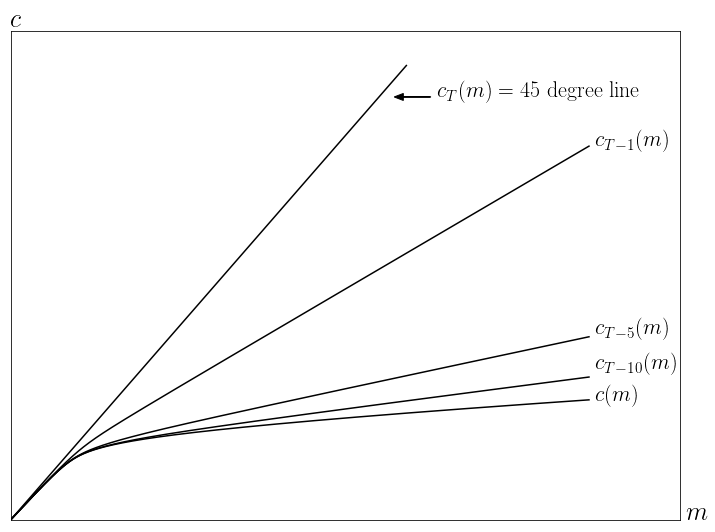

In [6]:
# Plot the different periods' consumption rules.

m1 = np.linspace(0,9.5,1000) # Set the plot range of m
m2 = np.linspace(0,6.5,500)
c_m  = baseEx.cFunc[0](m1)   # c_m can be used to define the limiting inﬁnite-horizon consumption rule here
c_t1 = baseEx.cFunc[-2](m1) # c_t1 defines the second-to-last period consumption rule
c_t5 = baseEx.cFunc[-6](m1) # c_t5 defines the T-5 period consumption rule
c_t10 = baseEx.cFunc[-11](m1)  # c_t10 defines the T-10 period consumption rule
c_t0 = m2                            # c_t0 defines the last period consumption rule
plt.figure(figsize = (12,9))
plt.plot(m1,c_m,color="black")
plt.plot(m1,c_t1,color="black")
plt.plot(m1,c_t5,color="black")
plt.plot(m1,c_t10,color="black")
plt.plot(m2,c_t0,color="black")
plt.xlim(0,11)
plt.ylim(0,7)
plt.text(7,6,r'$c_{T}(m) = 45$ degree line',fontsize = 22,fontweight='bold')
plt.text(9.6,5.3,r'$c_{T-1}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,2.6,r'$c_{T-5}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,2.1,r'$c_{T-10}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,1.7,r'$c(m)$',fontsize = 22,fontweight='bold')
plt.arrow(6.9,6.05,-0.6,0,head_width= 0.1,width=0.001,facecolor='black',length_includes_head='True')
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,7.05,"$c$",fontsize = 26)
plt.text(11.1,0,"$m$",fontsize = 26)
# Save the figures in several formats
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

## Factors and Conditions

### [The Finite Human Wealth Condition](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Human-Wealth)

Human wealth for a perfect foresight consumer is defined as the present discounted value of future income:

\begin{eqnarray}
H_{t} & = & \mathbb{E}[P_{t} + R^{-1} P_{t+1} + R^{2} P_{t+2} ... ] \\ 
      & = & P_{t}\mathbb{E}[P_{t} + (\Gamma/R) + (\Gamma/R)^{2} ... ]
\end{eqnarray}
which is an infinite number if $\Gamma/R \geq 1$.  We say that the 'Finite Human Wealth Condition' (FHWC) holds if 
$0 \leq (\Gamma/R) \leq 1$.

### [Absolute Patience and the AIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AIC)

The paper defines an object which it calls the Absolute Patience Factor, equal to the ratio of $C_{t+1}/C_{t}$ for a perfect foresight consumer.  The Old English character <span style="font-size:larger;">"&#222;"</span> is used for this object in the paper, but <span style="font-size:larger;">"&#222;"</span> cannot currently be rendered conveniently in Jupyter notebooks, so we will substitute $\Phi$ here:

\begin{equation}
\Phi = (R \beta)^{1/\rho} 
\end{equation}

If $\Phi = 1$, a perfect foresight consumer will spend exactly the amount that can be sustained perpetually (given their current and future resources).  If $\Phi < 1$ (the consumer is 'absolutely impatient'; or, 'the absolute impatience condition holds'), the consumer is consuming more than the sustainable amount, so consumption will fall, and if the consumer is 'absolutely patient' with $\Phi > 1$ consumption will grow over time.



### [Growth Patience and the GIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#GIC)

For a [perfect foresight consumer](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA), whether the ratio of consumption to the permanent component of income $P$ is rising, constant, or falling depends on the relative growth rates of consumption and permanent income, which is measured by the "Perfect Foresight Growth Patience Factor":

\begin{eqnarray}
\Phi_{\Gamma} & = & \Phi/\Gamma
\end{eqnarray}
and whether the ratio is falling or rising over time depends on whether $\Phi_{\Gamma}$ is below or above 1.

An analogous condition can be defined when there is uncertainty about permanent income.  Defining $\tilde{\Gamma} = (\mathbb{E}[\psi^{-1}])^{-1}\Gamma$, the 'Growth Impatience Condition' (GIC) is that 
\begin{eqnarray}
  \Phi/\tilde{\Gamma} & < & 1
\end{eqnarray}

### [The Finite Value of Autarky Condition (FVAC)](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Autarky-Value)

The paper [shows](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Autarky-Value) that a consumer who planned to spend his permanent income $\{ p_{t}, p_{t+1}, ...\} $ in every period would have value defined by

\begin{equation}
v_{t}^{\text{autarky}} = u(p_{t})\left(\frac{1}{1-\beta \Gamma^{1-\rho} \mathbb{E}[\psi^{1-\rho}]}\right)
\end{equation}

and defines the 'Finite Value of Autarky Condition' as the requirement that the denominator of this expression be a positive finite number:

\begin{equation}
\beta \Gamma^{1-\rho} \mathbb{E}[\psi^{1-\rho}] < 1
\end{equation}

### [The Weak Return Impatience Condition (WRIC)](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#WRIC)

The 'Return Impatience Condition' $\Phi/R < 1$ has long been understood to be required for the perfect foresight model to have a nondegenerate solution (when $\rho=1$, this reduces to $\beta < R$).  If the RIC does not hold, the consumer is so patient that the optimal consumption function approaches zero as the horizon extends.

When the probability of unemployment is $\wp$, the paper articulates an analogous (but weaker) condition:

\begin{eqnarray}
 \wp^{1/\rho} \Phi/R & < & 1
\end{eqnarray}

# Key Results

## [Nondegenerate Solution Requires FVAC and WRIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution)

A main result of the paper is that the conditions required for the model to have a nondegenerate solution ($0 < c(m) < \infty$ for feasible $m$) are that the Finite Value of Autarky (FVAC) and Weak Return Impatience Condition (WRAC) hold.

## [Natural Borrowing Constraint limits to Artificial Borrowing Constraint](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Liquidity-Constrained-Solution-as-a-Limit)

Defining $\chi(\wp)$ as the consumption function associated with any particular value of $\wp$, and defining $\hat{\chi}$ as the consumption function that would apply in the absence of the zero-income shocks but in the presence of an 'artificial' borrowing constraint requiring $a \geq 0$, a la Deaton (1991), the paper shows that 

\begin{eqnarray}
\lim_{\wp \downarrow 0}~\chi(\wp) & = & \hat{\chi}
\end{eqnarray}

That is, as $\wp$ approaches zero the problem with uncertainty becomes identical to the problem that instead has constraints.  (See [Precautionary Saving and Liquidity Constraints](http://econ.jhu.edu/people/ccarroll/papers/LiqConstr) for a full treatment of the relationship between precautionary saving and liquidity constraints).

## [$c(m)$ is Finite Even When Human Wealth Is Infinite](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#When-The-GIC-Fails)

In the perfect foresight model, if $R < \Gamma$ the present discounted value of future labor income is infinite and so the limiting consumption function is $c(m) = \infty$ for all $m$.  Many models have no well-defined solution in this case.

The presence of uncertainty changes this: The limiting consumption function is finite for all values of $m$.  

This is because uncertainty imposes a "natural borrowing constraint" that deters the consumer from borrowing against their unbounded future labor income.

A [table](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution) puts this result in the context of implications of other conditions and restrictions.



## [If the GIC Holds, $\exists$ a finite 'target' $m$](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#onetarget)

Section [There Is Exactly One Target $m$ Ratio, Which Is Stable](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#onetarget) shows that, under parameter values for which the limiting consumption function exists, if the GIC holds then there will be a value $\check{m}$ such that:

\begin{eqnarray}
\mathbb{E}[m_{t+1}] & > & m_{t}~\text{if $m_{t} < \check{m}$} \\
\mathbb{E}[m_{t+1}] & < & m_{t}~\text{if $m_{t} > \check{m}$} \\
\mathbb{E}[m_{t+1}] & = & m_{t}~\text{if $m_{t} = \check{m}$}
\end{eqnarray} 

## [If the GIC Fails, Target Wealth is Infinite ](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-GIC)

[A figure](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#FVACnotGIC) depicts a solution when the **FVAC** (Finite Value of Autarky Condition) and **WRIC** hold (so that the model has a solution) but the **GIC** (Growth Impatience Condition) fails.  In this case the target wealth ratio is infinity.  

The parameter values in this specific example are:

| Param | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.00 |
| $\mathrm{\mathsf{R}}$ | Interest Factor | $\texttt{Rfree}$ | 1.08 |

The figure is reproduced below.

In [8]:
# Construct the "GIC fails" example.
GIC_fail_dictionary = dict(base_params)
GIC_fail_dictionary['Rfree']      = 1.08
GIC_fail_dictionary['PermGroFac'] = [1.00]

GICFailExample = IndShockConsumerType(
    cycles=0, # cycles=0 makes this an infinite horizon consumer
    **GIC_fail_dictionary)

The given type violates the absolute impatience condition with the supplied parameter values; the AIF is 1.01823 
The given parameter values violate the growth impatience condition for this consumer type; the GIF is: 1.0088


The $\mathtt{IndShockConsumerType}$ tool automatically checks various parametric conditions, and will give a warning as well as the values of the factors if any conditions fail to be met. 

We can also directly check the conditions, in which case results will be a little more verbose by default.

In [9]:
# The checkConditions method does what it sounds like it would
GICFailExample.checkConditions(verbose=True)

The given type violates the absolute impatience condition with the supplied parameter values; the AIF is 1.01823 
    Therefore, the absolute amount of consumption is expected to grow over time
The given parameter values violate the growth impatience condition for this consumer type; the GIF is: 1.0088
    Therefore, a target level of wealth does not exist.
The weak return impatience factor value for the supplied parameter values satisfies the weak return impatience condition.
The finite value of autarky factor value for the supplied parameter values satisfies the finite value of autarky condition.

[!] For more information on the conditions, see Table 3 in "Theoretical Foundations of Buffer Stock Saving" at http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/


Next we define the function $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]$ that shows the ‘sustainable’ level of spending at which $m$ is expected to remain unchanged.

In [10]:
# Calculate "Sustainable" consumption that leaves expected m unchanged
# In the perfect foresight case, this is just permanent income plus interest income
# A small adjustment is required to take account of the consequences of uncertainty
InvEpShInvAct = np.dot(GICFailExample.PermShkDstn[0][0], GICFailExample.PermShkDstn[0][1]**(-1))
InvInvEpShInvAct = (InvEpShInvAct) ** (-1)
PermGroFacAct = GICFailExample.PermGroFac[0] * InvInvEpShInvAct
ER = GICFailExample.Rfree / PermGroFacAct
Er = ER - 1
mSSfunc = lambda m : 1 + (m-1)*(Er/ER)

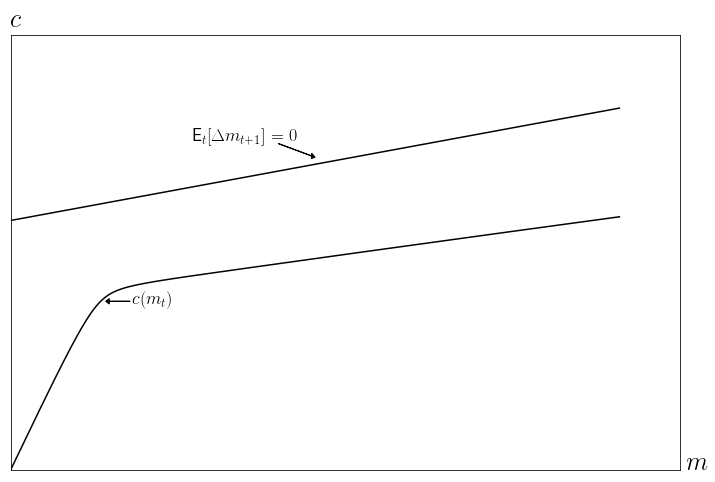

In [12]:
# Plot GICFailExample consumption function against the sustainable level of consumption
GICFailExample.solve() # Above, we set up the problem but did not solve it 
GICFailExample.unpackcFunc()  # Make the consumption function easily accessible for plotting
m = np.linspace(0,5,1000)
c_m = GICFailExample.cFunc[0](m)
E_m = mSSfunc(m)
plt.figure(figsize = (12,8))
plt.plot(m,c_m,color="black")
plt.plot(m,E_m,color="black")
plt.xlim(0,5.5)
plt.ylim(0,1.6)
plt.text(0,1.63,"$c$",fontsize = 26)
plt.text(5.55,0,"$m$",fontsize = 26)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(1,0.6,"$c(m_{t})$",fontsize = 18)
plt.text(1.5,1.2,"$\mathrm{\mathsf{E}}_{t}[\Delta m_{t+1}] = 0$",fontsize = 18)
plt.arrow(0.98,0.62,-0.2,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.2,1.2,0.3,-0.05,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.svg'))

# This figure reproduces the figure shown in the paper.  
# The gap between the two functions actually increases with $m$ in the limit.
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

As a foundation for the remaining figures, we define another instance of the class $\texttt{IndShockConsumerType}$, which has the same parameter values as the instance $\texttt{baseEx}$ defined previously but is solved to convergence (our definition of an infinite horizon agent type)


In [13]:
# cycles=0 tells the solver to find the infinite horizon solution
baseEx_inf = IndShockConsumerType(cycles=0,**base_params)

baseEx_inf.solve()
baseEx_inf.unpackcFunc()

### [Target $m$, Expected Consumption Growth, and Permanent Income Growth](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AnalysisoftheConvergedConsumptionFunction)

The next figure is shown in  [Analysis of the Converged Consumption Function](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cGroTargetFig), which shows the expected consumption growth factor $\mathrm{\mathbb{E}}_{t}[c_{t+1}/c_{t}]$ for a consumer behaving according to the converged consumption rule.


In [14]:
# Define a function to calculate expected consumption 
def exp_consumption(a):
    '''
    Taking end-of-period assets as input, return expectation of next period's consumption
    Inputs:
       a: end-of-period assets
    Returns:
       expconsump: next period's expected consumption
    '''
    GrowFactp1 = baseEx_inf.PermGroFac[0]* baseEx_inf.PermShkDstn[0][1]
    Rnrmtp1 = baseEx_inf.Rfree / GrowFactp1
    # end-of-period assets plus normalized returns
    btp1 = Rnrmtp1*a
    # expand dims of btp1 and use broadcasted sum of a column and a row vector
    # to obtain a matrix of possible beginning-of-period assets next period
    mtp1 = np.expand_dims(btp1, axis=1) + baseEx_inf.TranShkDstn[0][1]
    part_expconsumption = GrowFactp1*baseEx_inf.cFunc[0](mtp1).T
    # finish expectation over permanent income shocks by right multiplying with
    # the weights
    part_expconsumption = np.dot(part_expconsumption, baseEx_inf.PermShkDstn[0][0])
    # finish expectation over transitory income shocks by right multiplying with
    # weights
    expconsumption = np.dot(part_expconsumption, baseEx_inf.TranShkDstn[0][0])
    # return expected consumption
    return expconsumption

In [15]:
# Calculate the expected consumption growth factor
m1 = np.linspace(1,baseEx_inf.solution[0].mNrmSS,50) # m1 defines the plot range on the left of target m value (e.g. m <= target m)
c_m1 = baseEx_inf.cFunc[0](m1)
a1 = m1-c_m1
exp_consumption_l1 = []
for i in range(len(a1)):
    exp_consumption_tp1 = exp_consumption(a1[i])
    exp_consumption_l1.append(exp_consumption_tp1)

# growth1 defines the values of expected consumption growth factor when m is less than target m
growth1 = np.array(exp_consumption_l1)/c_m1

# m2 defines the plot range on the right of target m value (e.g. m >= target m)
m2 = np.linspace(baseEx_inf.solution[0].mNrmSS,1.9,50)

c_m2 = baseEx_inf.cFunc[0](m2)
a2 = m2-c_m2
exp_consumption_l2 = []
for i in range(len(a2)):
    exp_consumption_tp1 = exp_consumption(a2[i])
    exp_consumption_l2.append(exp_consumption_tp1)

# growth 2 defines the values of expected consumption growth factor when m is bigger than target m
growth2 = np.array(exp_consumption_l2)/c_m2

In [16]:
# Define a function to construct the arrows on the consumption growth rate function
def arrowplot(axes, x, y, narrs=15, dspace=0.5, direc='neg',
              hl=0.01, hw=3, c='black'):
    '''
    The function is used to plot arrows given the data x and y.

    Input:
        narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head

        hw     :  width of the arrow head

        c      :  color of the edge and face of the arrow head
    '''

    # r is the distance spanned between pairs of points
    r = np.sqrt(np.diff(x)**2+np.diff(y)**2)
    r = np.insert(r, 0, 0.0)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = np.cumsum(r)

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc is 'neg':
        dspace = -1.*abs(dspace)
    else:
        dspace = abs(dspace)

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]:
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2.0 + ax
        dy0 = np.cos(theta)*hl/2.0 + ay
        dx1 = -1.*np.sin(theta)*hl/2.0 + ax
        dy1 = -1.*np.cos(theta)*hl/2.0 + ay

        if direc is 'neg' :
            ax0 = dx0
            ay0 = dy0
            ax1 = dx1
            ay1 = dy1
        else:
            ax0 = dx1
            ay0 = dy1
            ax1 = dx0
            ay1 = dy0

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, frac=1., ec=c, fc=c))

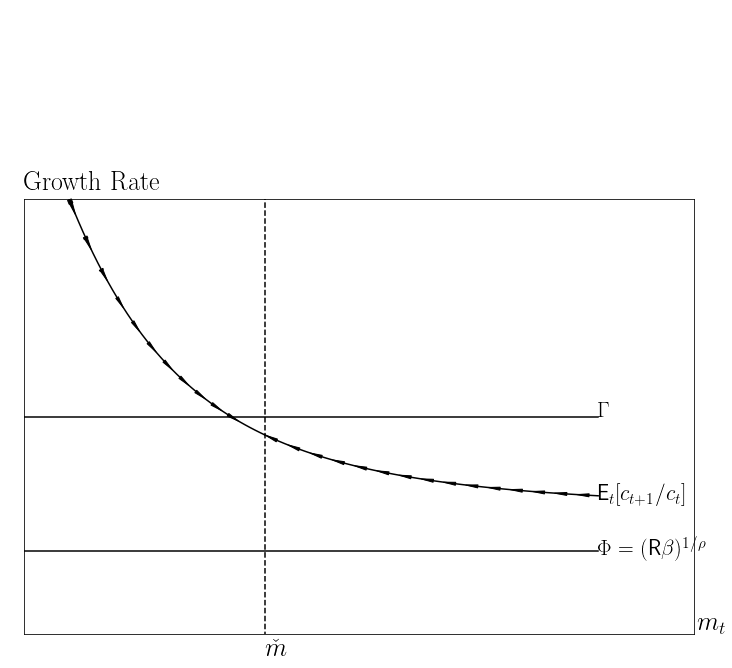

In [17]:
# Plot consumption growth as a function of market resources
# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
AbsPatientFac = (baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[AbsPatientFac,AbsPatientFac],color="black")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[baseEx_inf.PermGroFac[0],baseEx_inf.PermGroFac[0]],color="black")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(m1,growth1,color="black")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(m2,growth2,color="black")

# Plot the arrows
arrowplot(ax, m1,growth1)
arrowplot(ax, m2,growth2, direc='pos')

# Plot the target m
ax.plot([baseEx_inf.solution[0].mNrmSS,baseEx_inf.solution[0].mNrmSS],[0,1.4],color="black",linestyle="--")
ax.set_xlim(1,2.05)
ax.set_ylim(0.98,1.08)
ax.text(1,1.082,"Growth Rate",fontsize = 26,fontweight='bold')
ax.text(2.055,0.98,"$m_{t}$",fontsize = 26,fontweight='bold')
ax.text(1.9,1.01,"$\mathrm{\mathsf{E}}_{t}[c_{t+1}/c_{t}]$",fontsize = 22,fontweight='bold')
ax.text(baseEx_inf.solution[0].mNrmSS,0.975, r'$\check{m}$', fontsize = 26,fontweight='bold')
ax.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
ax.text(1.9,0.998,r'$\Phi = (\mathrm{\mathsf{R}}\beta)^{1/\rho}$',fontsize = 22,fontweight='bold')
ax.text(1.9,1.03, r'$\Gamma$',fontsize = 22,fontweight='bold')
if Generator:
    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.png'))
    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.jpg'))
    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.pdf'))
    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

### [Consumption Function Bounds](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AnalysisOfTheConvergedConsumptionFunction)
[The next figure](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cFuncBounds)
illustrates theoretical bounds for the consumption function.

We define two useful variables: lower bound of $\kappa$ (marginal propensity to consume) and limit of $h$ (Human wealth), along with some functions such as limiting perfect foresight consumption functions ($\bar{c}(m)$), $\bar{\bar c}(m)$ and $\underline{c}(m)$.

In [18]:
# Define k_lower, h_inf and perfect foresight consumption function, upper bound of consumption function and lower
# bound of consumption function.
k_lower = 1.0-(baseEx_inf.Rfree**(-1.0))*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)
h_inf = (1.0/(1.0-baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree))
conFunc_PF = lambda m: (h_inf -1)* k_lower + k_lower*m
conFunc_upper = lambda m: (1 - baseEx_inf.UnempPrb ** (1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)*m
conFunc_lower = lambda m: (1 -(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree) * m
intersect_m = ((h_inf-1)* k_lower)/((1 - baseEx_inf.UnempPrb
            **(1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)-k_lower)

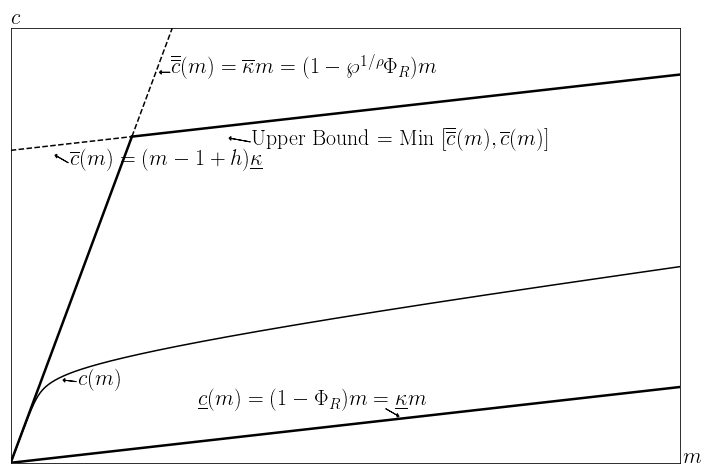

In [19]:
# Plot the consumption function and its bounds
x1 = np.linspace(0,25,1000)
x3 = np.linspace(0,intersect_m,300)
x4 = np.linspace(intersect_m,25,700)
cfunc_m = baseEx_inf.cFunc[0](x1)
cfunc_PF_1 = conFunc_PF(x3)
cfunc_PF_2 = conFunc_PF(x4)
cfunc_upper_1 = conFunc_upper(x3)
cfunc_upper_2 = conFunc_upper(x4)
cfunc_lower = conFunc_lower(x1)
plt.figure(figsize = (12,8))
plt.plot(x1,cfunc_m, color="black")
plt.plot(x1,cfunc_lower, color="black",linewidth=2.5)
plt.plot(x3,cfunc_upper_1, color="black",linewidth=2.5)
plt.plot(x4,cfunc_PF_2 , color="black",linewidth=2.5)
plt.plot(x4,cfunc_upper_2 , color="black",linestyle="--")
plt.plot(x3,cfunc_PF_1 , color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.xlim(0,25)
plt.ylim(0,1.12*conFunc_PF(25))
plt.text(0,1.12*conFunc_PF(25)+0.05,"$c$",fontsize = 22)
plt.text(25+0.1,0,"$m$",fontsize = 22)
plt.text(2.5,1,r'$c(m)$',fontsize = 22,fontweight='bold')
plt.text(6,5,r'$\overline{\overline c}(m)= \overline{\kappa}m = (1-\wp^{1/\rho}\Phi_{R})m$',fontsize = 22,fontweight='bold')
plt.text(2.2,3.8, r'$\overline{c}(m) = (m-1+h)\underline{\kappa}$',fontsize = 22,fontweight='bold')
plt.text(9,4.1,r'Upper Bound $ = $ Min $[\overline{\overline c}(m),\overline{c}(m)]$',fontsize = 22,fontweight='bold')
plt.text(7,0.7,r'$\underline{c}(m)= (1-\Phi_{R})m = \underline{\kappa}m$',fontsize = 22,fontweight='bold')
plt.arrow(2.45,1.05,-0.5,0.02,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.15,3.88,-0.5,0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(8.95,4.15,-0.8,0.05,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5.95,5.05,-0.4,0,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(14,0.70,0.5,-0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

### [The Consumption Function and Target $m$](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cFuncBounds)

This figure shows the $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]$ and consumption function $c(m_{t})$, along with the intrsection of these two functions, which defines the target value of $m$

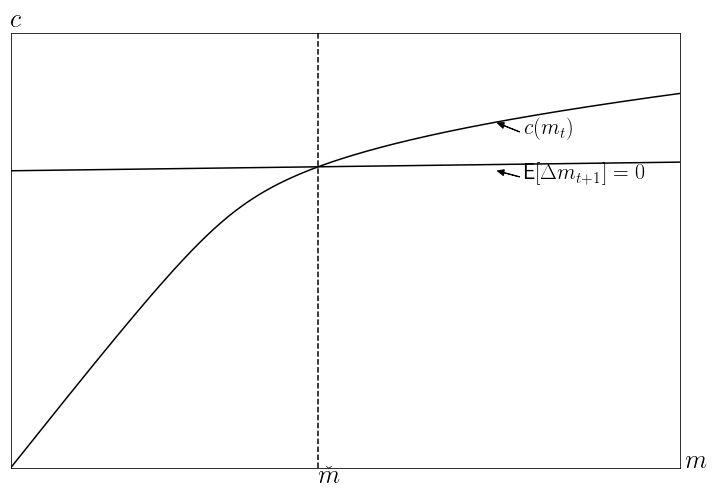

In [20]:
# This just plots objects that have already been constructed

m1 = np.linspace(0,4,1000)
cfunc_m = baseEx_inf.cFunc[0](m1)
mSSfunc = lambda m:(baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree)+(1.0-baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree)*m
mss = mSSfunc(m1)
plt.figure(figsize = (12,8))
plt.plot(m1,cfunc_m, color="black")
plt.plot(m1,mss, color="black")
plt.xlim(0,3)
plt.ylim(0,1.45)
plt.plot([baseEx_inf.solution[0].mNrmSS, baseEx_inf.solution[0].mNrmSS],[0,2.5],color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,1.47,r"$c$",fontsize = 26)
plt.text(3.02,0,r"$m$",fontsize = 26)
plt.text(2.3,0.95,r'$\mathrm{\mathsf{E}}[\Delta m_{t+1}] = 0$',fontsize = 22,fontweight='bold')
plt.text(2.3,1.1,r"$c(m_{t})$",fontsize = 22,fontweight='bold')
plt.text(baseEx_inf.solution[0].mNrmSS,-0.05, r"$\check{m}$",fontsize = 26)
plt.arrow(2.28,1.12,-0.1,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.28,0.97,-0.1,0.02,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.svg'))

### [Upper and Lower Limits of the Marginal Propensity to Consume](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#MPCLimits)

The paper shows that as $m_{t}~\uparrow~\infty$ the consumption function in the presence of risk gets arbitrarily close to the perfect foresight consumption function.  Defining $\underline{\kappa}$ as the perfect foresight model's MPC, this implies that $\lim_{m_{t}~\uparrow~\infty} c^{\prime}(m) = \underline{\kappa}$.  

The paper also derives an analytical limit $\bar{\kappa}$ for the MPC as $m$ approaches 0., its bounding value.  Strict concavity of the consumption function implies that the consumption function will be everywhere below a function $\bar{\kappa}m$, and strictly declining everywhere.  The last figure plots the MPC between these two limits.

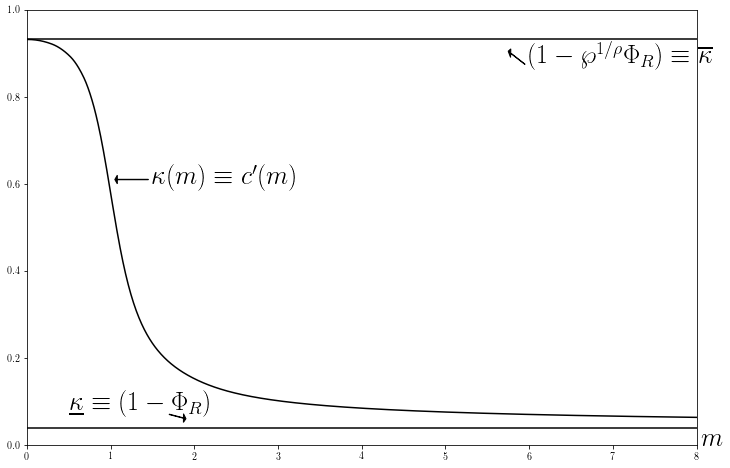

In [21]:
# The last figure shows the upper and lower limits of the MPC
plt.figure(figsize = (12,8))
# Set the plot range of m
m = np.linspace(0.001,8,1000)

# Use the HARK method derivative to get the derivative of cFunc, and the values are just the MPC
MPC = baseEx_inf.cFunc[0].derivative(m)

# Define the upper bound of MPC
MPCUpper = (1 - baseEx_inf.UnempPrb ** (1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)

# Define the lower bound of MPC
MPCLower = k_lower

plt.plot(m,MPC,color = 'black')
plt.plot([0,8],[MPCUpper,MPCUpper],color = 'black')
plt.plot([0,8],[MPCLower,MPCLower],color = 'black')
plt.xlim(0,8)
plt.ylim(0,1)
plt.text(1.5,0.6,r'$\kappa(m) \equiv c^{\prime}(m)$',fontsize = 26,fontweight='bold')
plt.text(6,0.87,r'$(1-\wp^{1/\rho}\Phi_{R})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold')
plt.text(0.5,0.07,r'$\underline{\kappa}\equiv(1-\Phi_{R})$',fontsize = 26,fontweight='bold')
plt.text(8.05,0,"$m$",fontsize = 26)
plt.arrow(1.45,0.61,-0.4,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(1.7,0.07,0.2,-0.01,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5.95,0.875,-0.2,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

# Summary

[Two tables in the paper](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution) summarize the various definitions, and then articulate conditions required for the problem to have a nondegenerate solution.

The main other contribution of the paper is to show that, under parametric combinations where the solution is nondegenerate, if the Growth Impatience Condition holds there will be a target level of wealth.